In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display, display_markdown

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import subprocess as sp
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import bambi
from copy import deepcopy
from scipy.stats import pearsonr, spearmanr

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 150

from subs2vec.utensils import log_timer
from subs2vec.vecs import Vectors
from subs2vec.neighbors import compute_nn

import logging
logging.getLogger().setLevel(logging.WARNING)

def display_md(md, **kwargs):
    return display_markdown(md, raw=True, **kwargs)

def convert_notebook(title, output='html'):
    convert = sp.run(f'jupyter nbconvert {title}.ipynb --to {output} --output {title}.{output}'.split(' '))
    if convert.returncode == 0:
        display_md(f'Jupyter notebook `{title}` converted successfully.')
    else:
        display_md(f'Error: encountered problem converting Jupyter notebook `{title}`')

def norm(x):
    return x / np.linalg.norm(x, 2)

def standardize(x):
    return (x - x.mean()) / x.std()

sns.set(style='whitegrid')
pd.options.mode.chained_assignment = None

# Loading and preparing data

In [2]:
df_joint = pd.read_csv('data/data_plus_predictors.tsv', sep='\t')
df_joint = df_joint[df_joint['dimension'] != 'high-low']
display(df_joint)

index    group              dimension          pp_id  color  rating  \
0          0  sighted               cold-hot      sighted_1  white       1   
1          1  sighted            ripe-unripe      sighted_1  white       7   
2          2  sighted                new-old      sighted_1  white       1   
3          3  sighted  submissive-aggressive      sighted_1  white       1   
4          4  sighted       selfless-jealous      sighted_1  white       1   
...      ...      ...                    ...            ...    ...     ...   
42974  28506  sighted              soft-hard  sighted_68129    red       5   
42975  28507  sighted            light-heavy  sighted_68129    red       5   
42976  28508  sighted          relaxed-tense  sighted_68129    red       5   
42977  28509  sighted             alive-dead  sighted_68129    red       6   
42978  28510  sighted              fast-slow  sighted_68129    red       3   

          experiment self_vs_other   art  fiction  ...  sighted  group_eff  \
0           original          self   NaN      NaN  ...        1        1.0   
1           original          self   NaN      NaN  ...        1        1.0   
2           original          self   NaN      NaN  ...        1        1.0   
3           original          self   NaN      NaN  ...        1        1.0   
4           original          self   NaN      NaN  ...        1        1.0   
...              ...           ...   ...      ...  ...      ...        ...   
42974  replication_2         other  11.0      0.0  ...        1        1.0   
42975  replication_2         other  11.0      0.0  ...        1        1.0   
42976  replication_2         other  11.0      0.0  ...        1        1.0   
42977  replication_2         other  11.0      0.0  ...        1        1.0   
42978  replication_2         other  11.0      0.0  ...        1        1.0   

        group_z  original  replication_1  replication_2 other self  \
0      0.211241         1              0              0     0    1   
1      0.211241         1              0              0     0    1   
2      0.211241         1              0              0     0    1   
3      0.211241         1              0              0     0    1   
4      0.211241         1              0              0     0    1   
...         ...       ...            ...            ...   ...  ...   
42974  0.211241         0              0              1     1    0   
42975  0.211241         0              0              1     1    0   
42976  0.211241         0              0              1     1    0   
42977  0.211241         0              0              1     1    0   
42978  0.211241         0              0              1     1    0   

       self_vs_other_eff  self_vs_other_z  
0                   -1.0        -0.891882  
1                   -1.0        -0.891882  
2                   -1.0        -0.891882  
3                   -1.0        -0.891882  
4                   -1.0        -0.891882  
...                  ...              ...  
42974                1.0         1.121199  
42975                1.0         1.121199  
42976                1.0         1.121199  
42977                1.0         1.121199  
42978                1.0         1.121199  

[40866 rows x 74 columns]

# How similar are the ratings in our replication data to the original Saysani sighted sample?

In [3]:
replication = df_joint[df_joint['experiment'] == 'replication_1'].groupby(['dimension', 'color']).mean()
original = df_joint[(df_joint['experiment'] == 'original') & (df_joint['group'] == 'sighted')].groupby(['dimension', 'color']).mean()
r = pearsonr(replication['rating'], original['rating'])
print(f'r(original, replication) = {r[0]:.2f}, p = {r[1]:.3f}')
r = spearmanr(replication['rating'], original['rating'])
print(f'rank r(original, replication) = {r[0]:.2f}, p = {r[1]:.3f}')

r(original, replication) = 0.89, p = 0.000
rank r(original, replication) = 0.87, p = 0.000


# How similar are blind and sighted participants' ratings?

In [4]:
blind = df_joint[df_joint['group'] == 'blind'].groupby(['dimension', 'color']).mean()
sighted = df_joint[((df_joint['experiment'] == 'original') | (df_joint['experiment'] == 'replication_1'))
                   & (df_joint['group'] == 'sighted')].groupby(['dimension', 'color']).mean()
r = pearsonr(blind['rating'], sighted['rating'])
print(f'r(blind, sighted) = {r[0]:.2f}, p = {r[1]:.3f}')
r = spearmanr(blind['rating'], sighted['rating'])
print(f'rank r(blind, sighted) = {r[0]:.2f}, p = {r[1]:.3f}')

r(blind, sighted) = 0.75, p = 0.000
rank r(blind, sighted) = 0.72, p = 0.000


# Predictiveness of different embeddings for the ratings from the original experiment and our first replication
## Common Crawl

In [8]:
m_cc = bambi.Model('rating_z ~ 1'
    + ' + group_eff*frequency_z'
    + ' + group_eff*concreteness_z'
    + ' + group_eff*cosine_cc_z'
    + ' + group_eff*swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_cc_z + swow_all_z|pp_id)'
    + ' + (1 + group_eff|dimension)'
    + ' + (1 + group_eff|color)',
    df_joint[(df_joint['experiment'] != 'replication_2') & (df_joint['self_vs_other'] == 'self')]
)
r_cc = m_cc.fit(
    init='advi+adapt_diag',
    chains=4,
    draws=1000,
    tune=1000,
    n_init=10000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 16,694
[INFO] Finished [100%]: Average Loss = 16,694
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_cc_z, group_eff:cosine_cc_z, swow_all_z, group_eff:swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_cc_z|pp_id_sigma, cosine_cc_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, group_eff|dimension_sigma, group_eff|dimension_offset, 1|color_sigma, 1|color_offset, group_eff|color_sigma, group_eff|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_cc_z, group_eff:cosine_cc_z, swow_all_z, group_eff:swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, fre

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 464 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 464 seconds.


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
blind:cosine_cc_z    0.119  0.066    -0.015       0.24      0.002    0.001   
sighted:cosine_cc_z  0.388  0.032     0.327       0.45      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
blind:cosine_cc_z      1745.0    2499.0    1.0  
sighted:cosine_cc_z    5501.0    3326.0    1.0

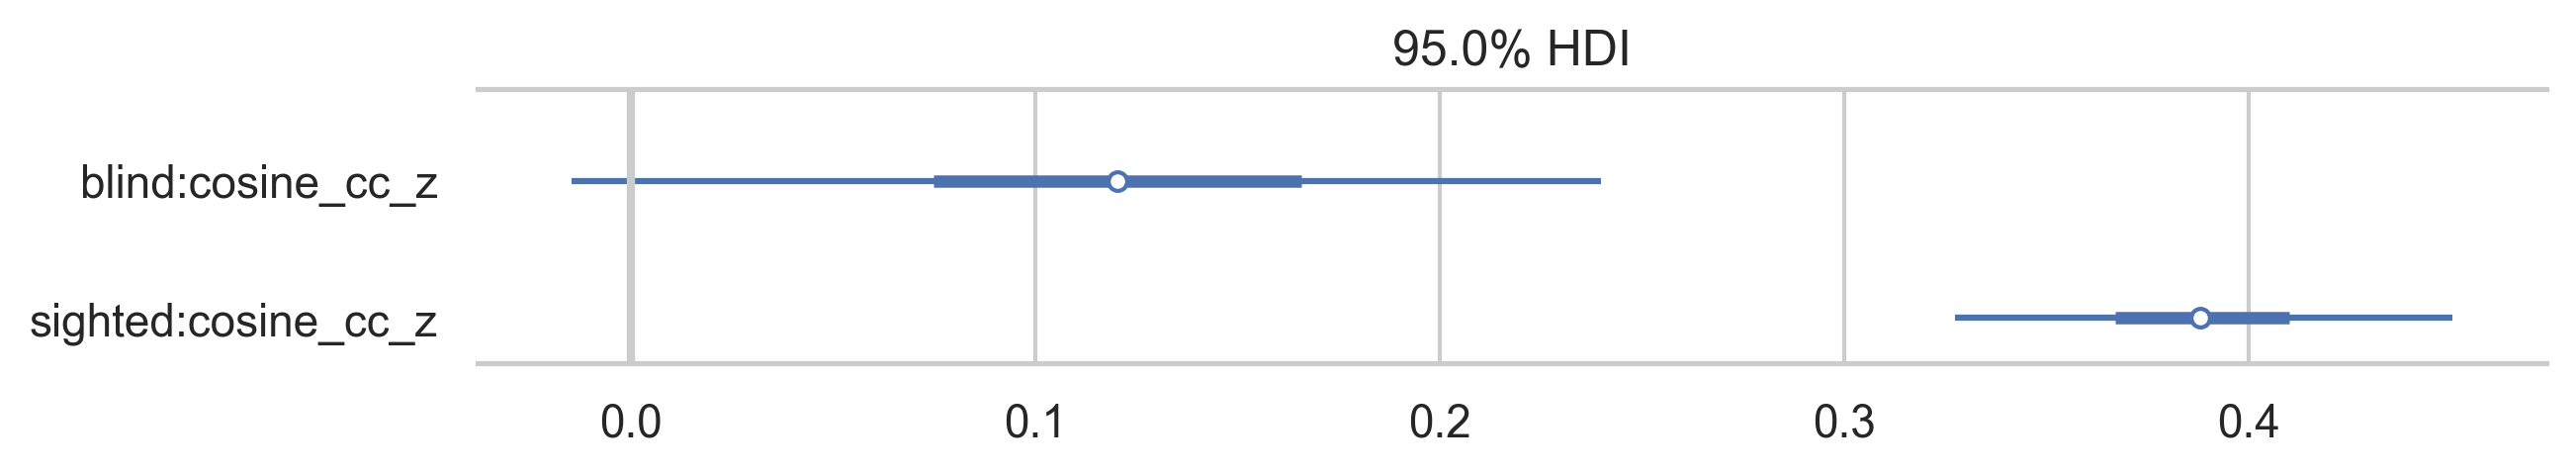

In [9]:
# compute and plot conditional effect of cosine in sighted and blind groups
trace = deepcopy(r_cc.posterior)
# effect of cosine in blind group in orginal experiment
trace['blind:cosine_cc_z'] = trace['cosine_cc_z'] - trace['group_eff:cosine_cc_z']
    # effect of cosine in sighted group across both experiments
trace['sighted:cosine_cc_z'] = trace['cosine_cc_z'] + trace['group_eff:cosine_cc_z']

varnames = ['blind:cosine_cc_z', 'sighted:cosine_cc_z']
g = az.plot_forest(trace, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);
display(az.summary(trace, hdi_prob=.95, var_names=varnames))

## OpenSubtitles

In [10]:
m_subs = bambi.Model('rating_z ~ 1'
    + ' + group_eff*frequency_z'
    + ' + group_eff*concreteness_z'
    + ' + group_eff*cosine_subs_z'
    + ' + group_eff*swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_subs_z + swow_all_z|pp_id)'
    + ' + (1 + group_eff|dimension)'
    + ' + (1 + group_eff|color)',
    df_joint[(df_joint['experiment'] != 'replication_2') & (df_joint['self_vs_other'] == 'self')]
)
r_subs = m_subs.fit(
    init='advi+adapt_diag',
    chains=4,
    draws=1000,
    tune=1000,
    n_init=10000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 16,573
[INFO] Finished [100%]: Average Loss = 16,573
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_subs_z, group_eff:cosine_subs_z, swow_all_z, group_eff:swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_subs_z|pp_id_sigma, cosine_subs_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, group_eff|dimension_sigma, group_eff|dimension_offset, 1|color_sigma, 1|color_offset, group_eff|color_sigma, group_eff|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_subs_z, group_eff:cosine_subs_z, swow_all_z, group_eff:swow_all_z, 1|pp_id_sigma, 1|pp_id

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 470 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 470 seconds.


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
blind:cosine_cc_z      0.119  0.066    -0.015      0.240      0.002    0.001   
sighted:cosine_cc_z    0.388  0.032     0.327      0.450      0.000    0.000   
blind:cosine_subs_z    0.225  0.047     0.134      0.315      0.001    0.001   
sighted:cosine_subs_z  0.446  0.024     0.398      0.493      0.000    0.000   

                       ess_bulk  ess_tail  r_hat  
blind:cosine_cc_z        1745.0    2499.0    1.0  
sighted:cosine_cc_z      5501.0    3326.0    1.0  
blind:cosine_subs_z      2846.0    3226.0    1.0  
sighted:cosine_subs_z    6598.0    3293.0    1.0

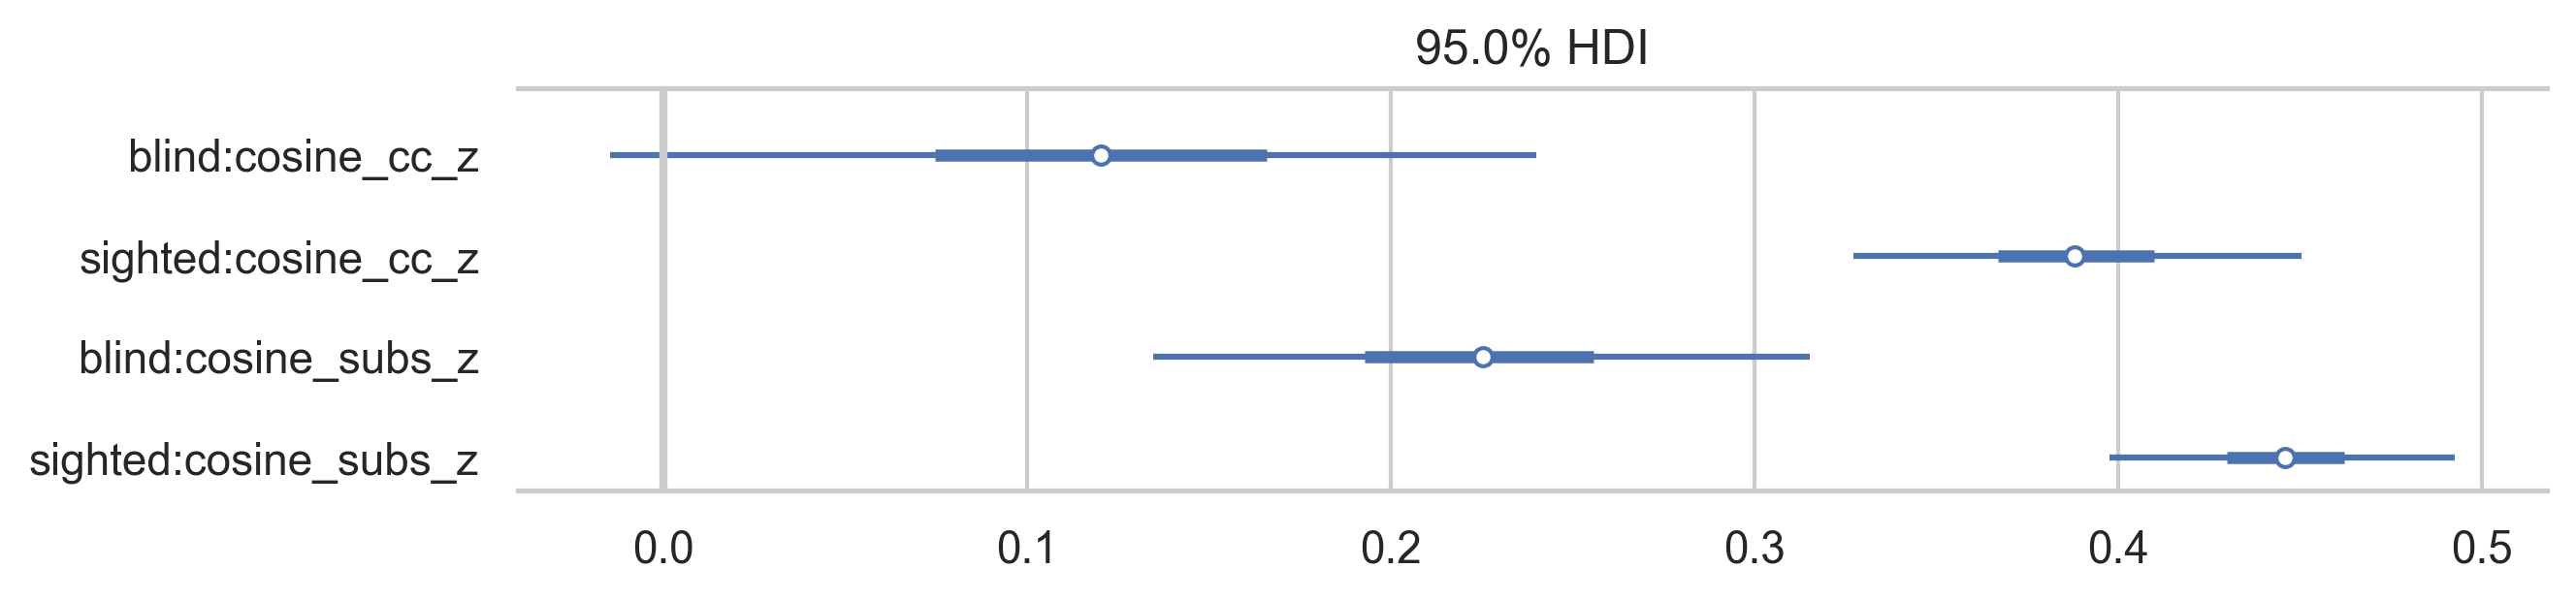

In [11]:
# compute and plot conditional effect of cosine in sighted and blind groups
trace_subs = deepcopy(r_subs.posterior)
# effect of cosine in blind group in orginal experiment
trace['blind:cosine_subs_z'] = trace_subs['cosine_subs_z'] - trace_subs['group_eff:cosine_subs_z']
# effect of cosine in sighted group across both experiments
trace['sighted:cosine_subs_z'] = trace_subs['cosine_subs_z'] + trace_subs['group_eff:cosine_subs_z']

varnames = [
    'blind:cosine_cc_z', 'sighted:cosine_cc_z',
    'blind:cosine_subs_z', 'sighted:cosine_subs_z',
]
g = az.plot_forest(trace, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);
display(az.summary(trace, hdi_prob=.95, var_names=varnames))

## COCA-fiction

In [5]:
m_fic = bambi.Model('rating_z ~ 1'
    + ' + group_eff*frequency_z'
    + ' + group_eff*concreteness_z'
    + ' + group_eff*cosine_fic_z'
    + ' + group_eff*swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_z + swow_all_z|pp_id)'
    + ' + (1 + group_eff|dimension)'
    + ' + (1 + group_eff|color)',
    df_joint[(df_joint['experiment'] != 'replication_2') & (df_joint['self_vs_other'] == 'self')]
)
r_fic = m_fic.fit(
    init='advi+adapt_diag',
    chains=4,
    draws=1000,
    tune=1000,
    n_init=10000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 16,632
[INFO] Finished [100%]: Average Loss = 16,632
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_fic_z, group_eff:cosine_fic_z, swow_all_z, group_eff:swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_z|pp_id_sigma, cosine_fic_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, group_eff|dimension_sigma, group_eff|dimension_offset, 1|color_sigma, 1|color_offset, group_eff|color_sigma, group_eff|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_fic_z, group_eff:cosine_fic_z, swow_all_z, group_eff:swow_all_z, 1|pp_id_sigma, 1|pp_id_offse

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 466 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 466 seconds.


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
blind:cosine_cc_z      0.119  0.066    -0.015      0.240      0.002    0.001   
sighted:cosine_cc_z    0.388  0.032     0.327      0.450      0.000    0.000   
blind:cosine_subs_z    0.225  0.047     0.134      0.315      0.001    0.001   
sighted:cosine_subs_z  0.446  0.024     0.398      0.493      0.000    0.000   
blind:cosine_fic_z     0.340  0.053     0.241      0.445      0.001    0.001   
sighted:cosine_fic_z   0.495  0.027     0.444      0.548      0.000    0.000   

                       ess_bulk  ess_tail  r_hat  
blind:cosine_cc_z        1745.0    2499.0    1.0  
sighted:cosine_cc_z      5501.0    3326.0    1.0  
blind:cosine_subs_z      2846.0    3226.0    1.0  
sighted:cosine_subs_z    6598.0    3293.0    1.0  
blind:cosine_fic_z       1912.0    2704.0    1.0  
sighted:cosine_fic_z     5625.0    2970.0    1.0

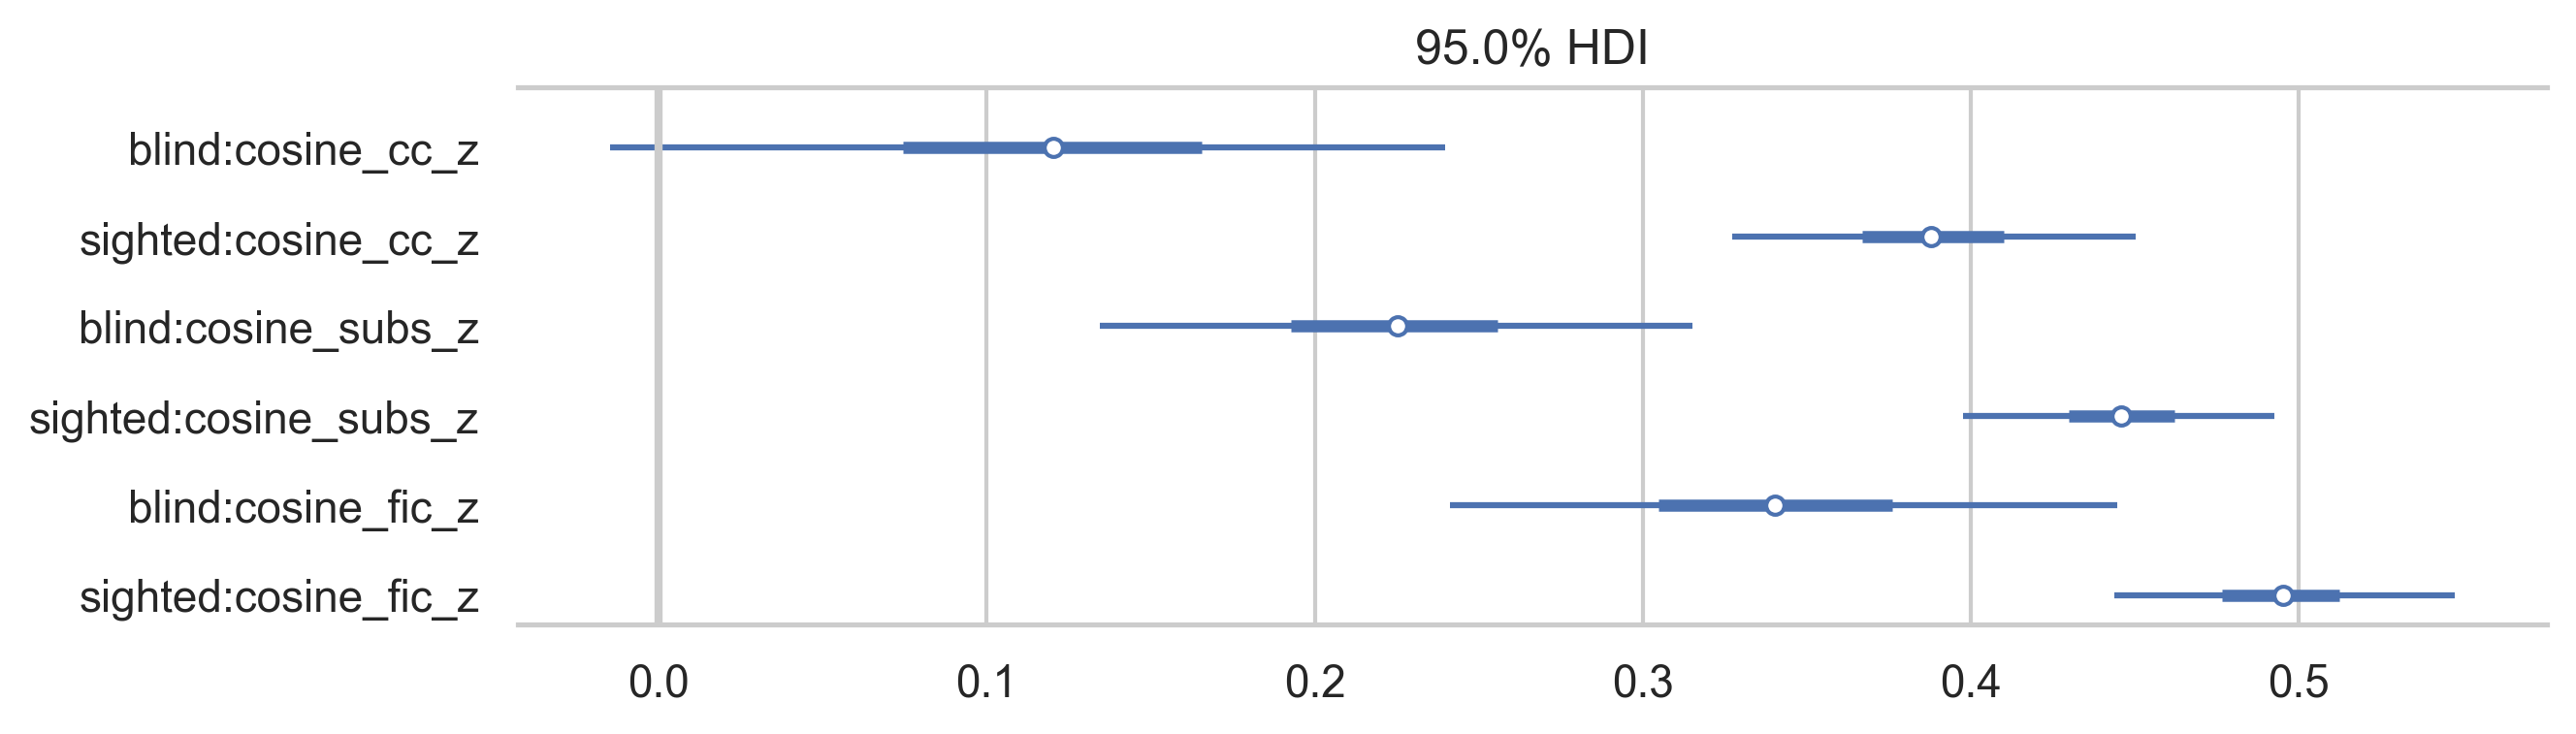

In [17]:
# compute and plot conditional effect of cosine in sighted and blind groups
trace_fic = deepcopy(r_fic.posterior)
# effect of cosine in blind group in orginal experiment
trace['blind:cosine_fic_z'] = trace_fic['cosine_fic_z'] - trace_fic['group_eff:cosine_fic_z']
# effect of cosine in sighted group across both experiments
trace['sighted:cosine_fic_z'] = trace_fic['cosine_fic_z'] + trace_fic['group_eff:cosine_fic_z']

varnames = [
    'blind:cosine_cc_z', 'sighted:cosine_cc_z',
    'blind:cosine_subs_z', 'sighted:cosine_subs_z',
    'blind:cosine_fic_z', 'sighted:cosine_fic_z',
]
g = az.plot_forest(trace, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);
display(az.summary(trace, hdi_prob=.95, var_names=varnames))

## COCA-spoken

In [6]:
m_spok = bambi.Model('rating_z ~ 1'
    + ' + group_eff*frequency_z'
    + ' + group_eff*concreteness_z'
    + ' + group_eff*cosine_spok_z'
    + ' + group_eff*swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_spok_z + swow_all_z|pp_id)'
    + ' + (1 + group_eff|dimension)'
    + ' + (1 + group_eff|color)',
    df_joint[(df_joint['experiment'] != 'replication_2') & (df_joint['self_vs_other'] == 'self')]
)
r_spok = m_spok.fit(
    init='advi+adapt_diag',
    chains=4,
    draws=1000,
    tune=1000,
    n_init=10000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 16,708
[INFO] Finished [100%]: Average Loss = 16,708
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_spok_z, group_eff:cosine_spok_z, swow_all_z, group_eff:swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_spok_z|pp_id_sigma, cosine_spok_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, group_eff|dimension_sigma, group_eff|dimension_offset, 1|color_sigma, 1|color_offset, group_eff|color_sigma, group_eff|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, group_eff, frequency_z, group_eff:frequency_z, concreteness_z, group_eff:concreteness_z, cosine_spok_z, group_eff:cosine_spok_z, swow_all_z, group_eff:swow_all_z, 1|pp_id_sigma, 1|pp_id

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 449 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 449 seconds.


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
blind:cosine_cc_z      0.119  0.066    -0.015      0.240      0.002    0.001   
sighted:cosine_cc_z    0.388  0.032     0.327      0.450      0.000    0.000   
blind:cosine_subs_z    0.225  0.047     0.134      0.315      0.001    0.001   
sighted:cosine_subs_z  0.446  0.024     0.398      0.493      0.000    0.000   
blind:cosine_fic_z     0.340  0.053     0.241      0.445      0.001    0.001   
sighted:cosine_fic_z   0.495  0.027     0.444      0.548      0.000    0.000   
blind:cosine_spok_z    0.055  0.041    -0.028      0.135      0.001    0.001   
sighted:cosine_spok_z  0.145  0.024     0.096      0.191      0.000    0.000   

                       ess_bulk  ess_tail  r_hat  
blind:cosine_cc_z        1745.0    2499.0    1.0  
sighted:cosine_cc_z      5501.0    3326.0    1.0  
blind:cosine_subs_z      2846.0    3226.0    1.0  
sighted:cosine_subs_z    6598.0    3293.0    1.0  
blind:cosine_fic_z       1912.0    2704.0    1.0  
sighted:cosine_fic_z     5625.0    2970.0    1.0  
blind:cosine_spok_z      1878.0    2455.0    1.0  
sighted:cosine_spok_z    5146.0    3389.0    1.0

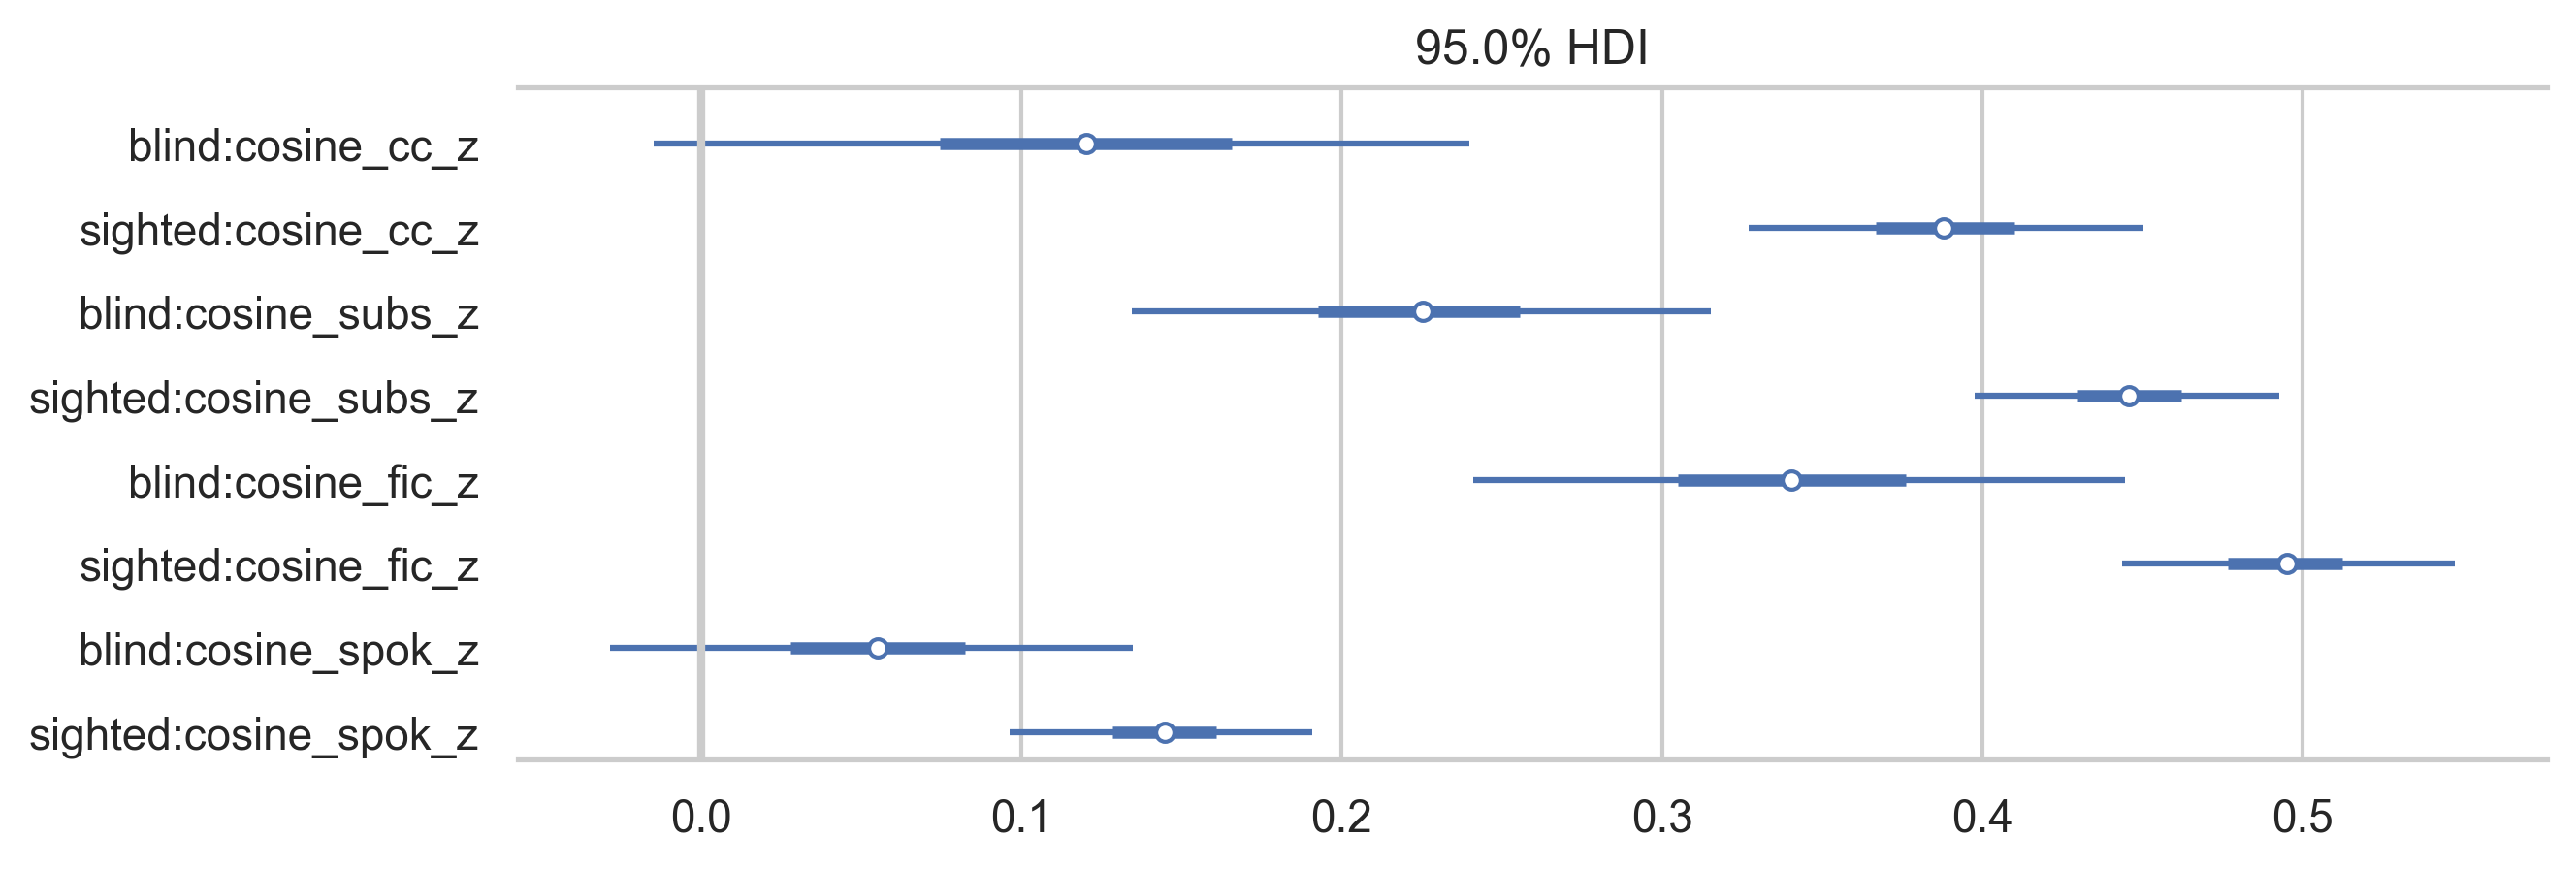

In [19]:
# compute and plot conditional effect of cosine in sighted and blind groups
trace_spok = deepcopy(r_spok.posterior)
# effect of cosine in blind group in orginal experiment
trace['blind:cosine_spok_z'] = trace_spok['cosine_spok_z'] - trace_spok['group_eff:cosine_spok_z']
# effect of cosine in sighted group across both experiments
trace['sighted:cosine_spok_z'] = trace_spok['cosine_spok_z'] + trace_spok['group_eff:cosine_spok_z']

varnames = [
    'blind:cosine_cc_z', 'sighted:cosine_cc_z',
    'blind:cosine_subs_z', 'sighted:cosine_subs_z',
    'blind:cosine_fic_z', 'sighted:cosine_fic_z',
    'blind:cosine_spok_z', 'sighted:cosine_spok_z',
]
g = az.plot_forest(trace, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);
display(az.summary(trace, hdi_prob=.95, var_names=varnames))

## Combined conditional effects plot (effects of each different embedding projection in the blind and sighted groups)

/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.00392156862745098, 0.45098039215686275, 0.6980392156862745)) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.8705882352941177, 0.5607843137254902, 0.0196078431372549)) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


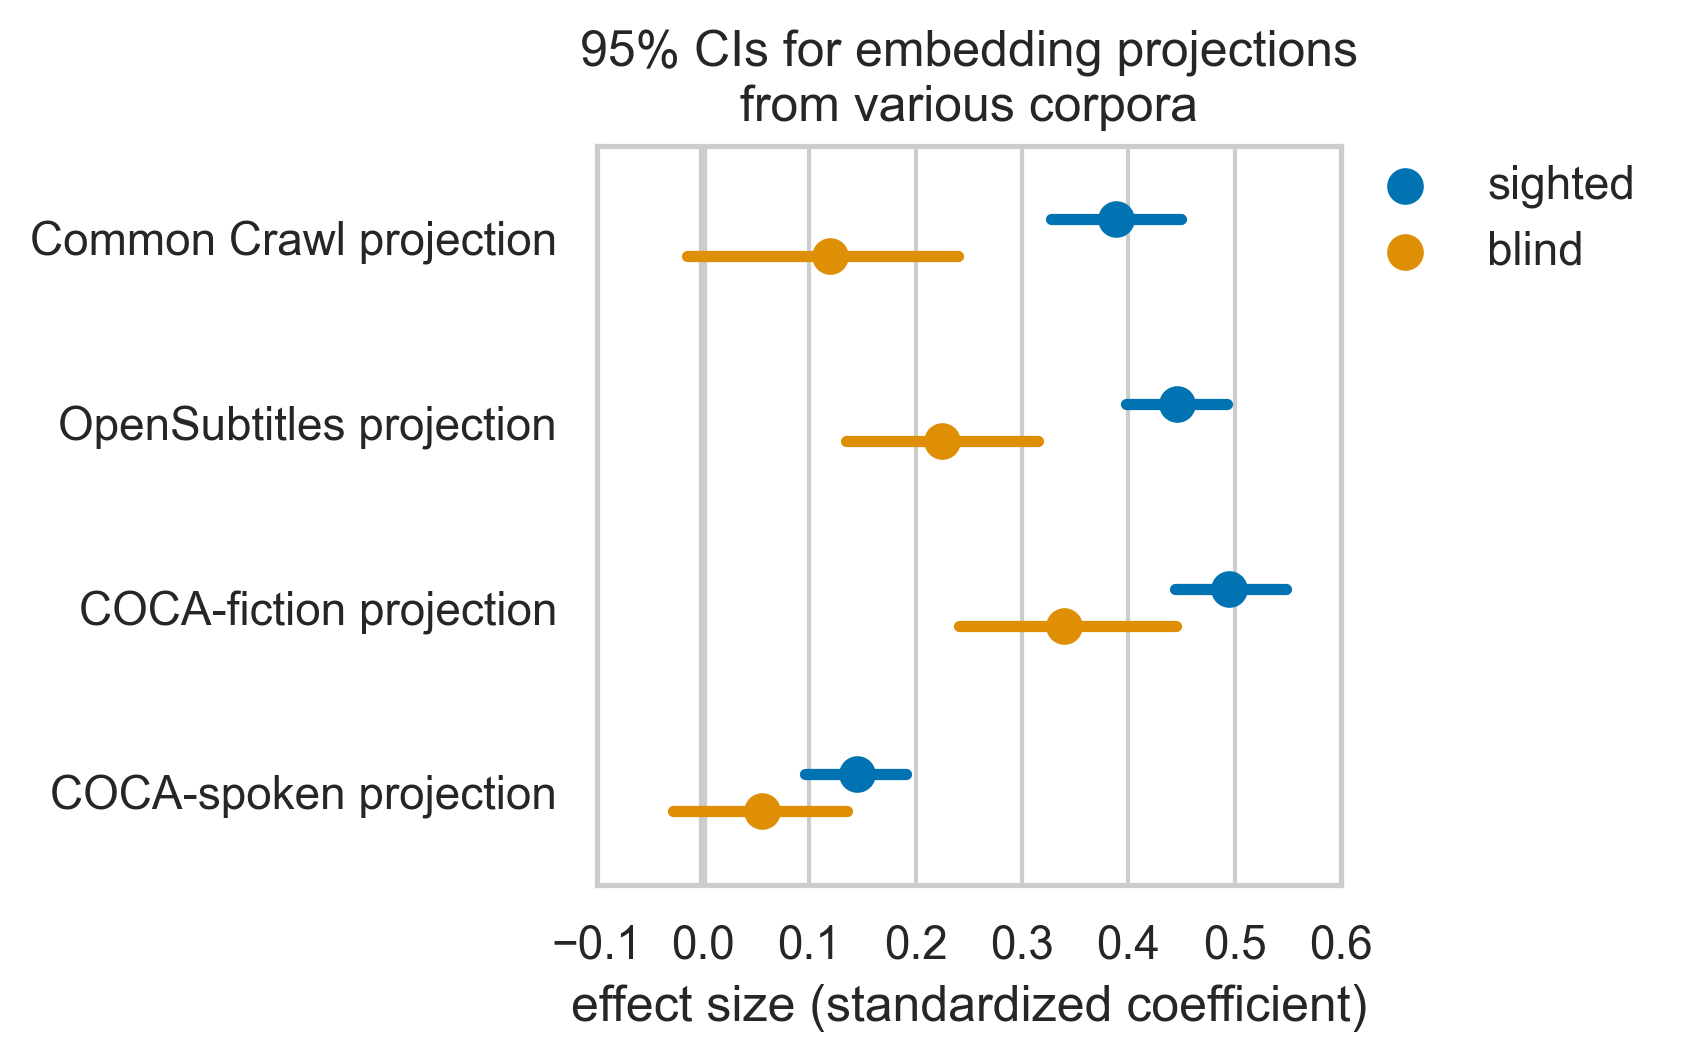

In [20]:
varnames = [
    'sighted:cosine_cc_z',
    'sighted:cosine_subs_z',
    'sighted:cosine_fic_z',
    'sighted:cosine_spok_z',
    'blind:cosine_cc_z',
    'blind:cosine_subs_z',
    'blind:cosine_fic_z',
    'blind:cosine_spok_z',
]
trace_df = az.summary(trace, hdi_prob=.95, var_names=varnames).reset_index()
sns.set(palette='colorblind', style='whitegrid')
trace_df['group'] = trace_df['index'].apply(lambda x: x.split(':')[0])
trace_df['predictor'] = trace_df['index'].apply(lambda x: x.split(':')[1])
g, ax = plt.subplots(figsize=[3.2, 3.2])
ax.axvline(0, color='.8', linewidth=2)
varnames = [
    'sighted:cosine_cc_z',
    'sighted:cosine_subs_z',
    'sighted:cosine_fic_z',
    'sighted:cosine_spok_z',
    'blind:cosine_cc_z',
    'blind:cosine_subs_z',
    'blind:cosine_fic_z',
    'blind:cosine_spok_z',
]
order = [
    'cosine_cc_z',
    'cosine_subs_z',
    'cosine_fic_z',
    'cosine_spok_z',
]
sns.pointplot(data=trace_df, hue='group', x='mean', y='predictor', join=False, ax=ax, order=order,
              palette=sns.color_palette()[0:], dodge=.2)
hdi_df = trace_df.melt(id_vars=['predictor', 'group'], value_vars=['hdi_2.5%', 'hdi_97.5%'])
sns.pointplot(data=hdi_df, hue='group', markers='', x='value', order=order,
              y='predictor', ax=ax, join=False,
              palette=sns.color_palette()[0:], dodge=.2)
ax.set(xlim=[-.1, .6], xticks=[-.1, 0, .1, .2, .3, .4, .5, .6],
       ylabel='', xlabel='effect size (standardized coefficient)',
       title='95% CIs for embedding projections\nfrom various corpora')
ax.set(yticklabels=[
    'Common Crawl projection',
    'OpenSubtitles projection',
    'COCA-fiction projection',
    'COCA-spoken projection',
])
labels = ax.get_legend_handles_labels()
ax.legend(handles=labels[0][:2], labels=labels[1][:2],
          bbox_to_anchor=(1, 1), loc=2, borderaxespad=0, frameon=False)
plt.savefig('figures/corpus_variation_forest.pdf', bbox_inches='tight')

## Comparing models on leave-one-out validation score
Instead of using conditional effect sizes from the models as a comparison, we can also compare the models on their out-of-sample predictive accuracy. Essentially we're looking to see which predictor, if included, makes the model _worst_.  
Using prediction/cross-validation for model comparison has distinct advantages in some situations, but in our case (when we're not varying model complexity or structure, but only replacing a single predictor) the results will probably match our inferences from the conditional effect size plots.

In [21]:
display(az.compare({
    'COCA fiction': r_fic,
    'COCA spoken': r_spok,
    'Common Crawl': r_cc,
    'OpenSubtitles': r_subs,
}).round(2))

/opt/homebrew/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Est

rank  elpd_loo   p_loo  elpd_diff  weight     se    dse  \
COCA fiction      0 -13497.35  157.23       0.00    0.52  64.91   0.00   
OpenSubtitles     1 -13505.92  162.67       8.57    0.48  65.04  19.67   
Common Crawl      2 -13608.02  160.27     110.68    0.00  64.65  19.18   
COCA spoken       3 -13687.66  155.01     190.32    0.00  64.16  19.76   

               warning scale  
COCA fiction      True   log  
OpenSubtitles     True   log  
Common Crawl      True   log  
COCA spoken       True   log

As expected, the model with COCA-fiction performs best, although the subtitle model is a close second. These models have in common that they contain many well-formed sentences of a decent length, which contain references to color in both literal and metaphorical sense.

The comparison algorithm does warn that the shape parameter of the pareto distribution is too large for some observations. This is common with hierarchical models and shouldn't be a problem if it concerns only a few observations. We can check this by inspecting the LOO-statistics more closely.

In [22]:
az.loo(r_fic)

/opt/homebrew/lib/python3.9/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 9417 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -13497.35    64.91
p_loo      157.23        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     9408   99.9%
 (0.5, 0.7]   (ok)          7    0.1%
   (0.7, 1]   (bad)         2    0.0%
   (1, Inf)   (very bad)    0    0.0%

It appears that for the COCA-fiction model, for instance, there are only 3 observations in the "bad" range. This is not overly problematic given the nearly 10,000 observations that are in the correct range.

## Visual model diagnostics
R-hat and other Markov chain diagnostics looked good, but it's still worth doing a few quick visual model checks.
### Quick look at the trace plots
We want all the Markov chains for a single variable to look lined up in the density plot on the left, but nice and fuzzy (i.e. not autocorrelated) on the right.

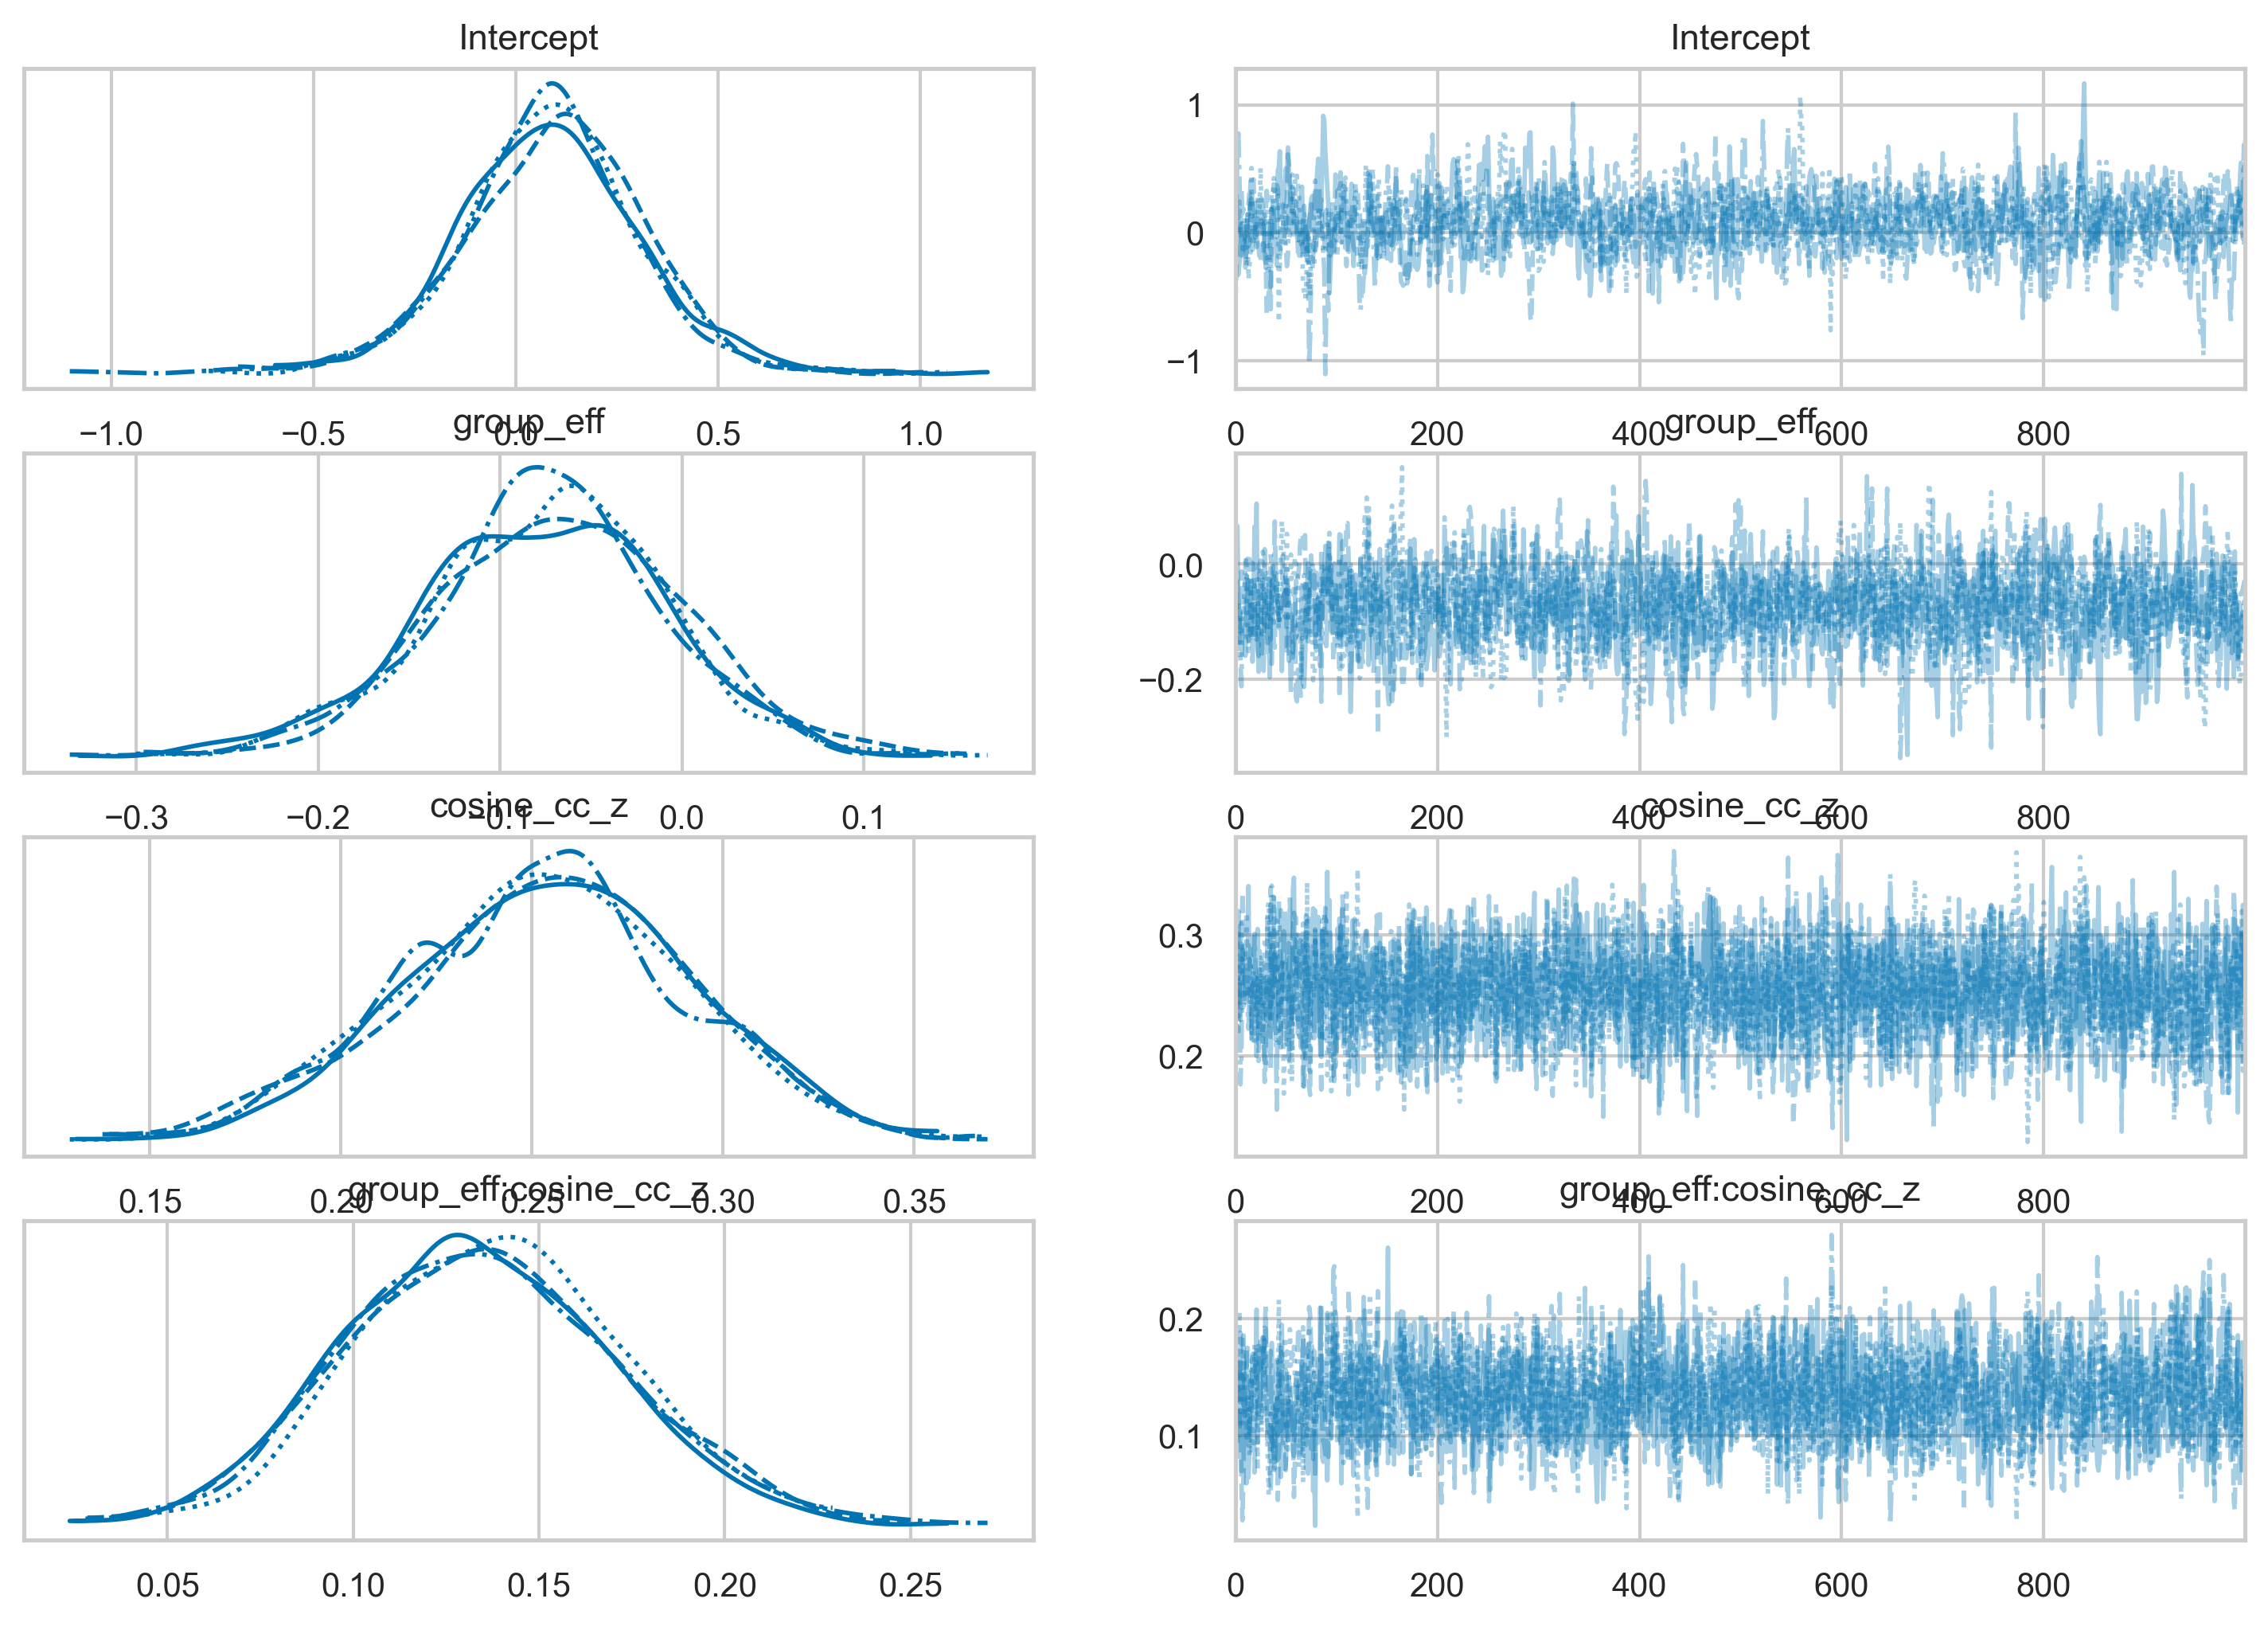

In [27]:
g = az.plot_trace(r_cc, var_names=['Intercept', 'group_eff', 'cosine_cc_z', 'group_eff:cosine_cc_z'])

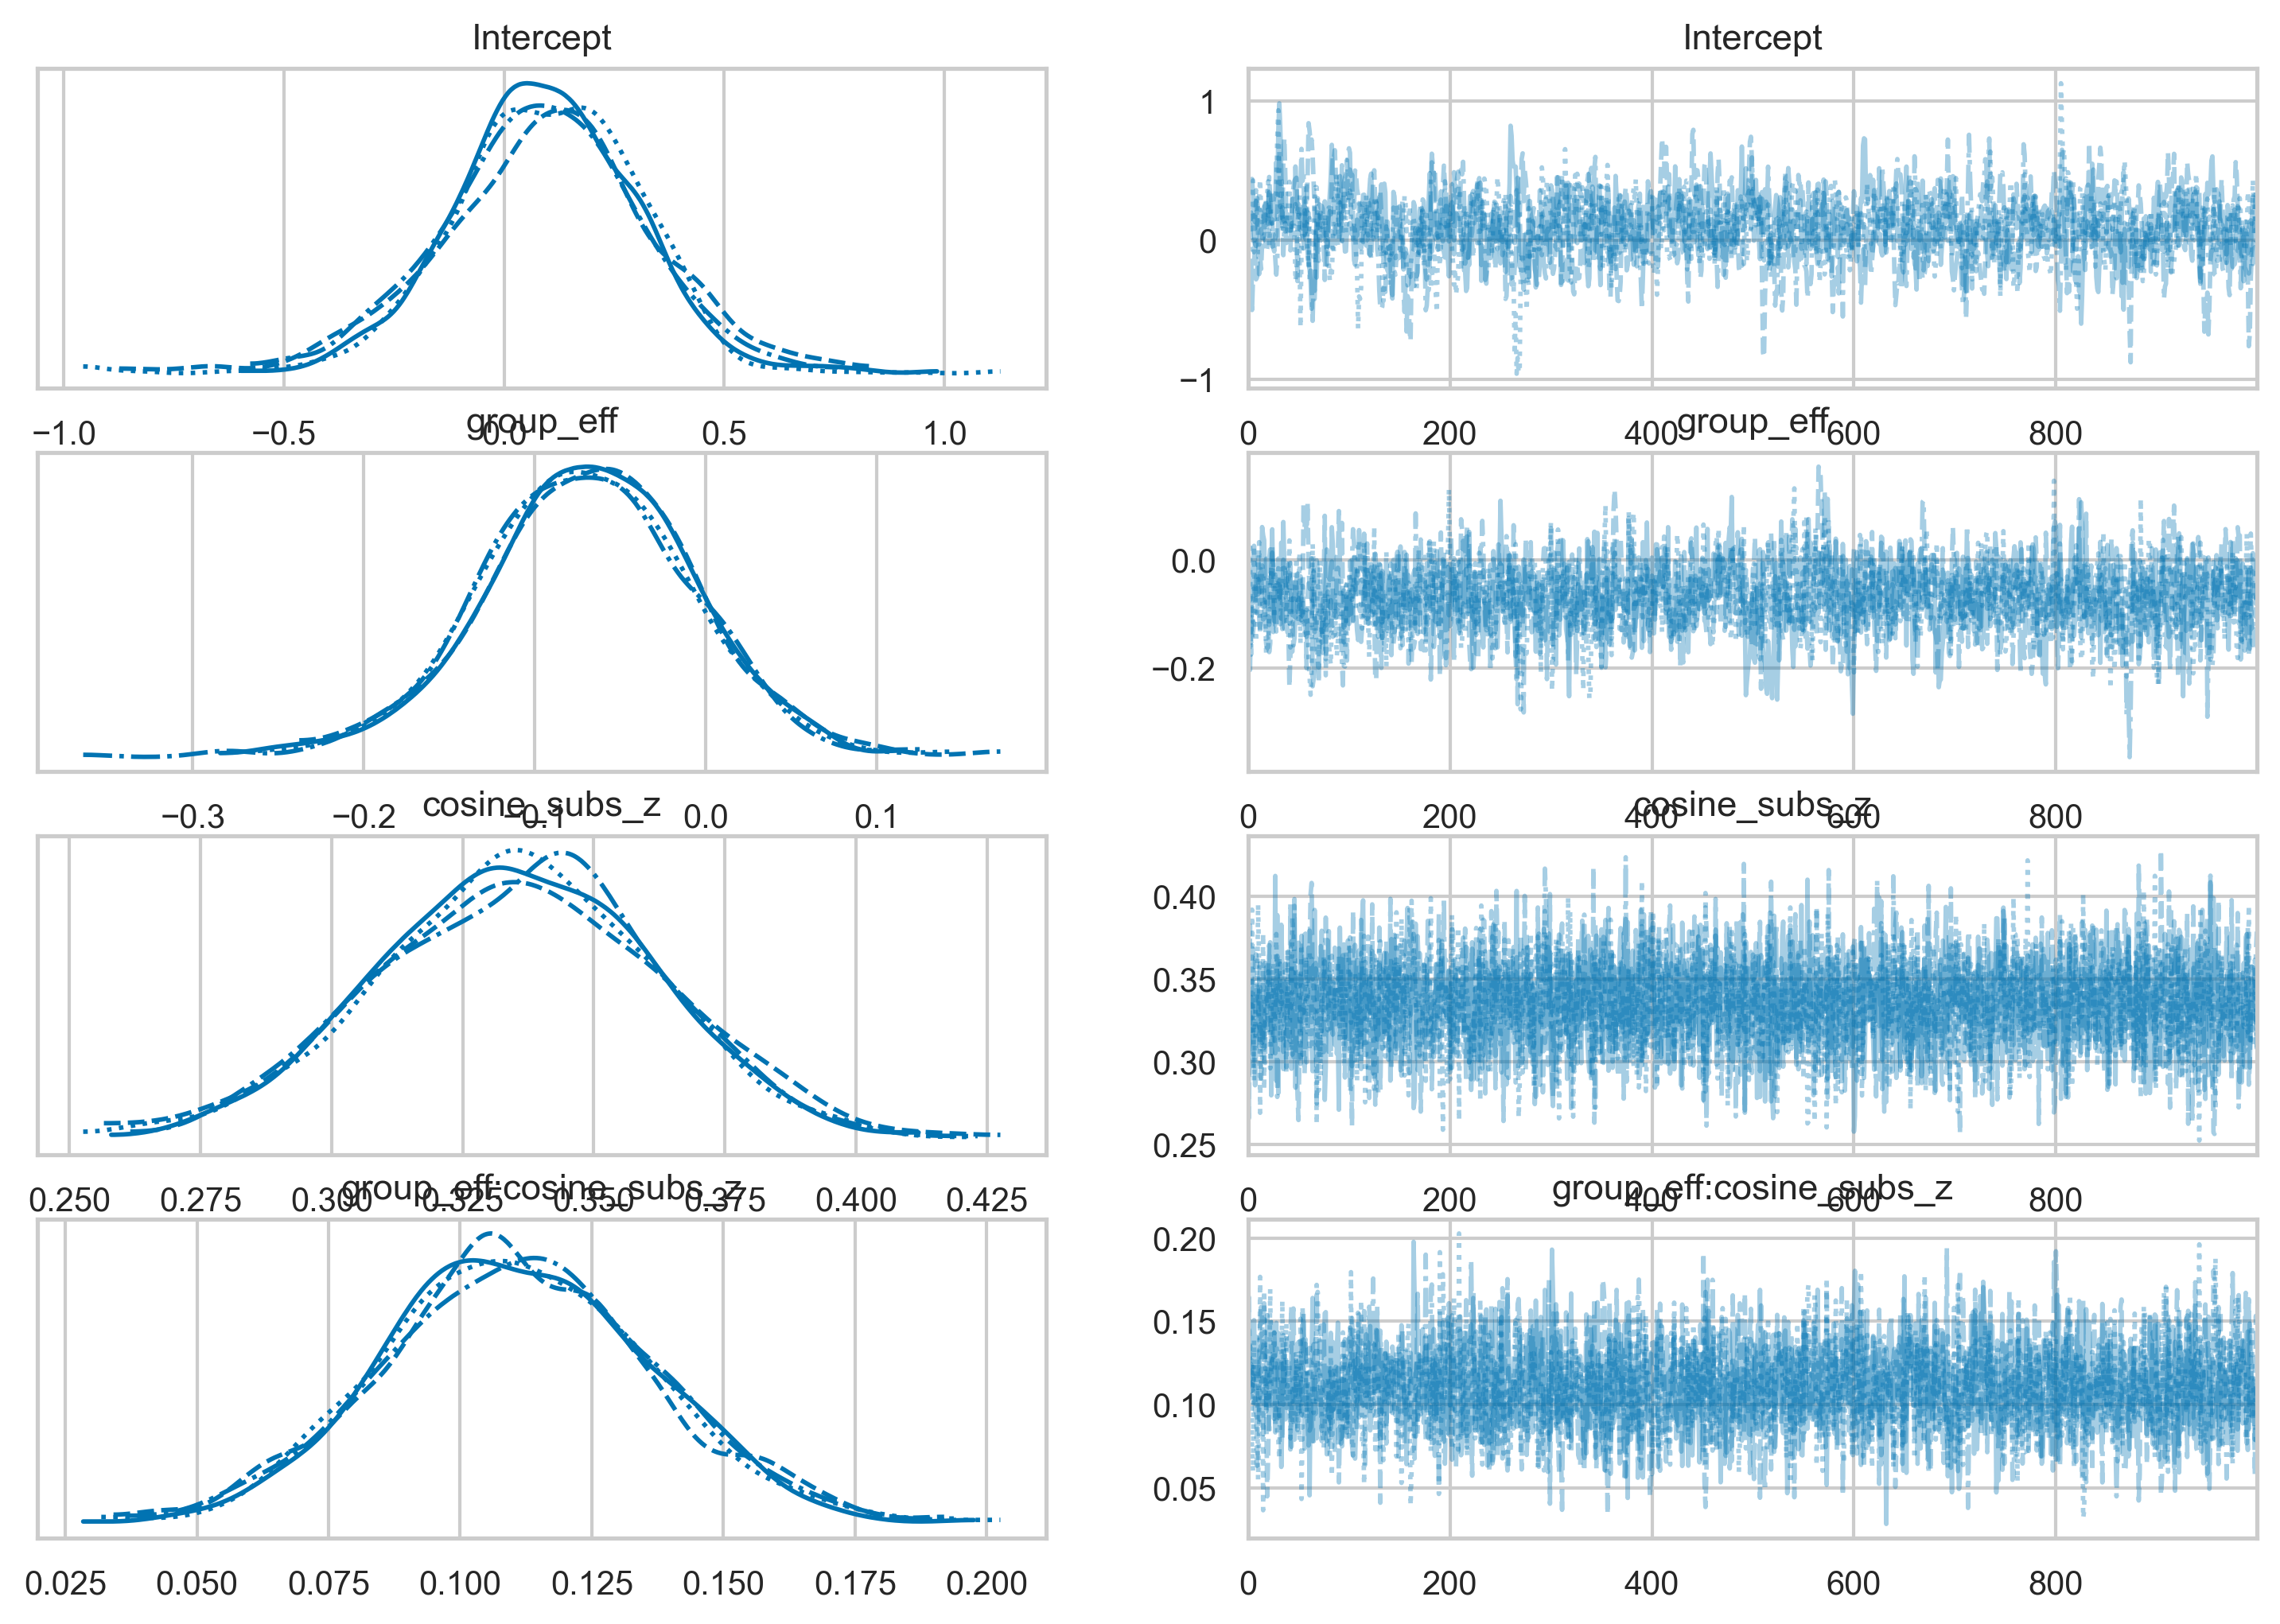

In [28]:
g = az.plot_trace(r_subs, var_names=['Intercept', 'group_eff', 'cosine_subs_z', 'group_eff:cosine_subs_z'])

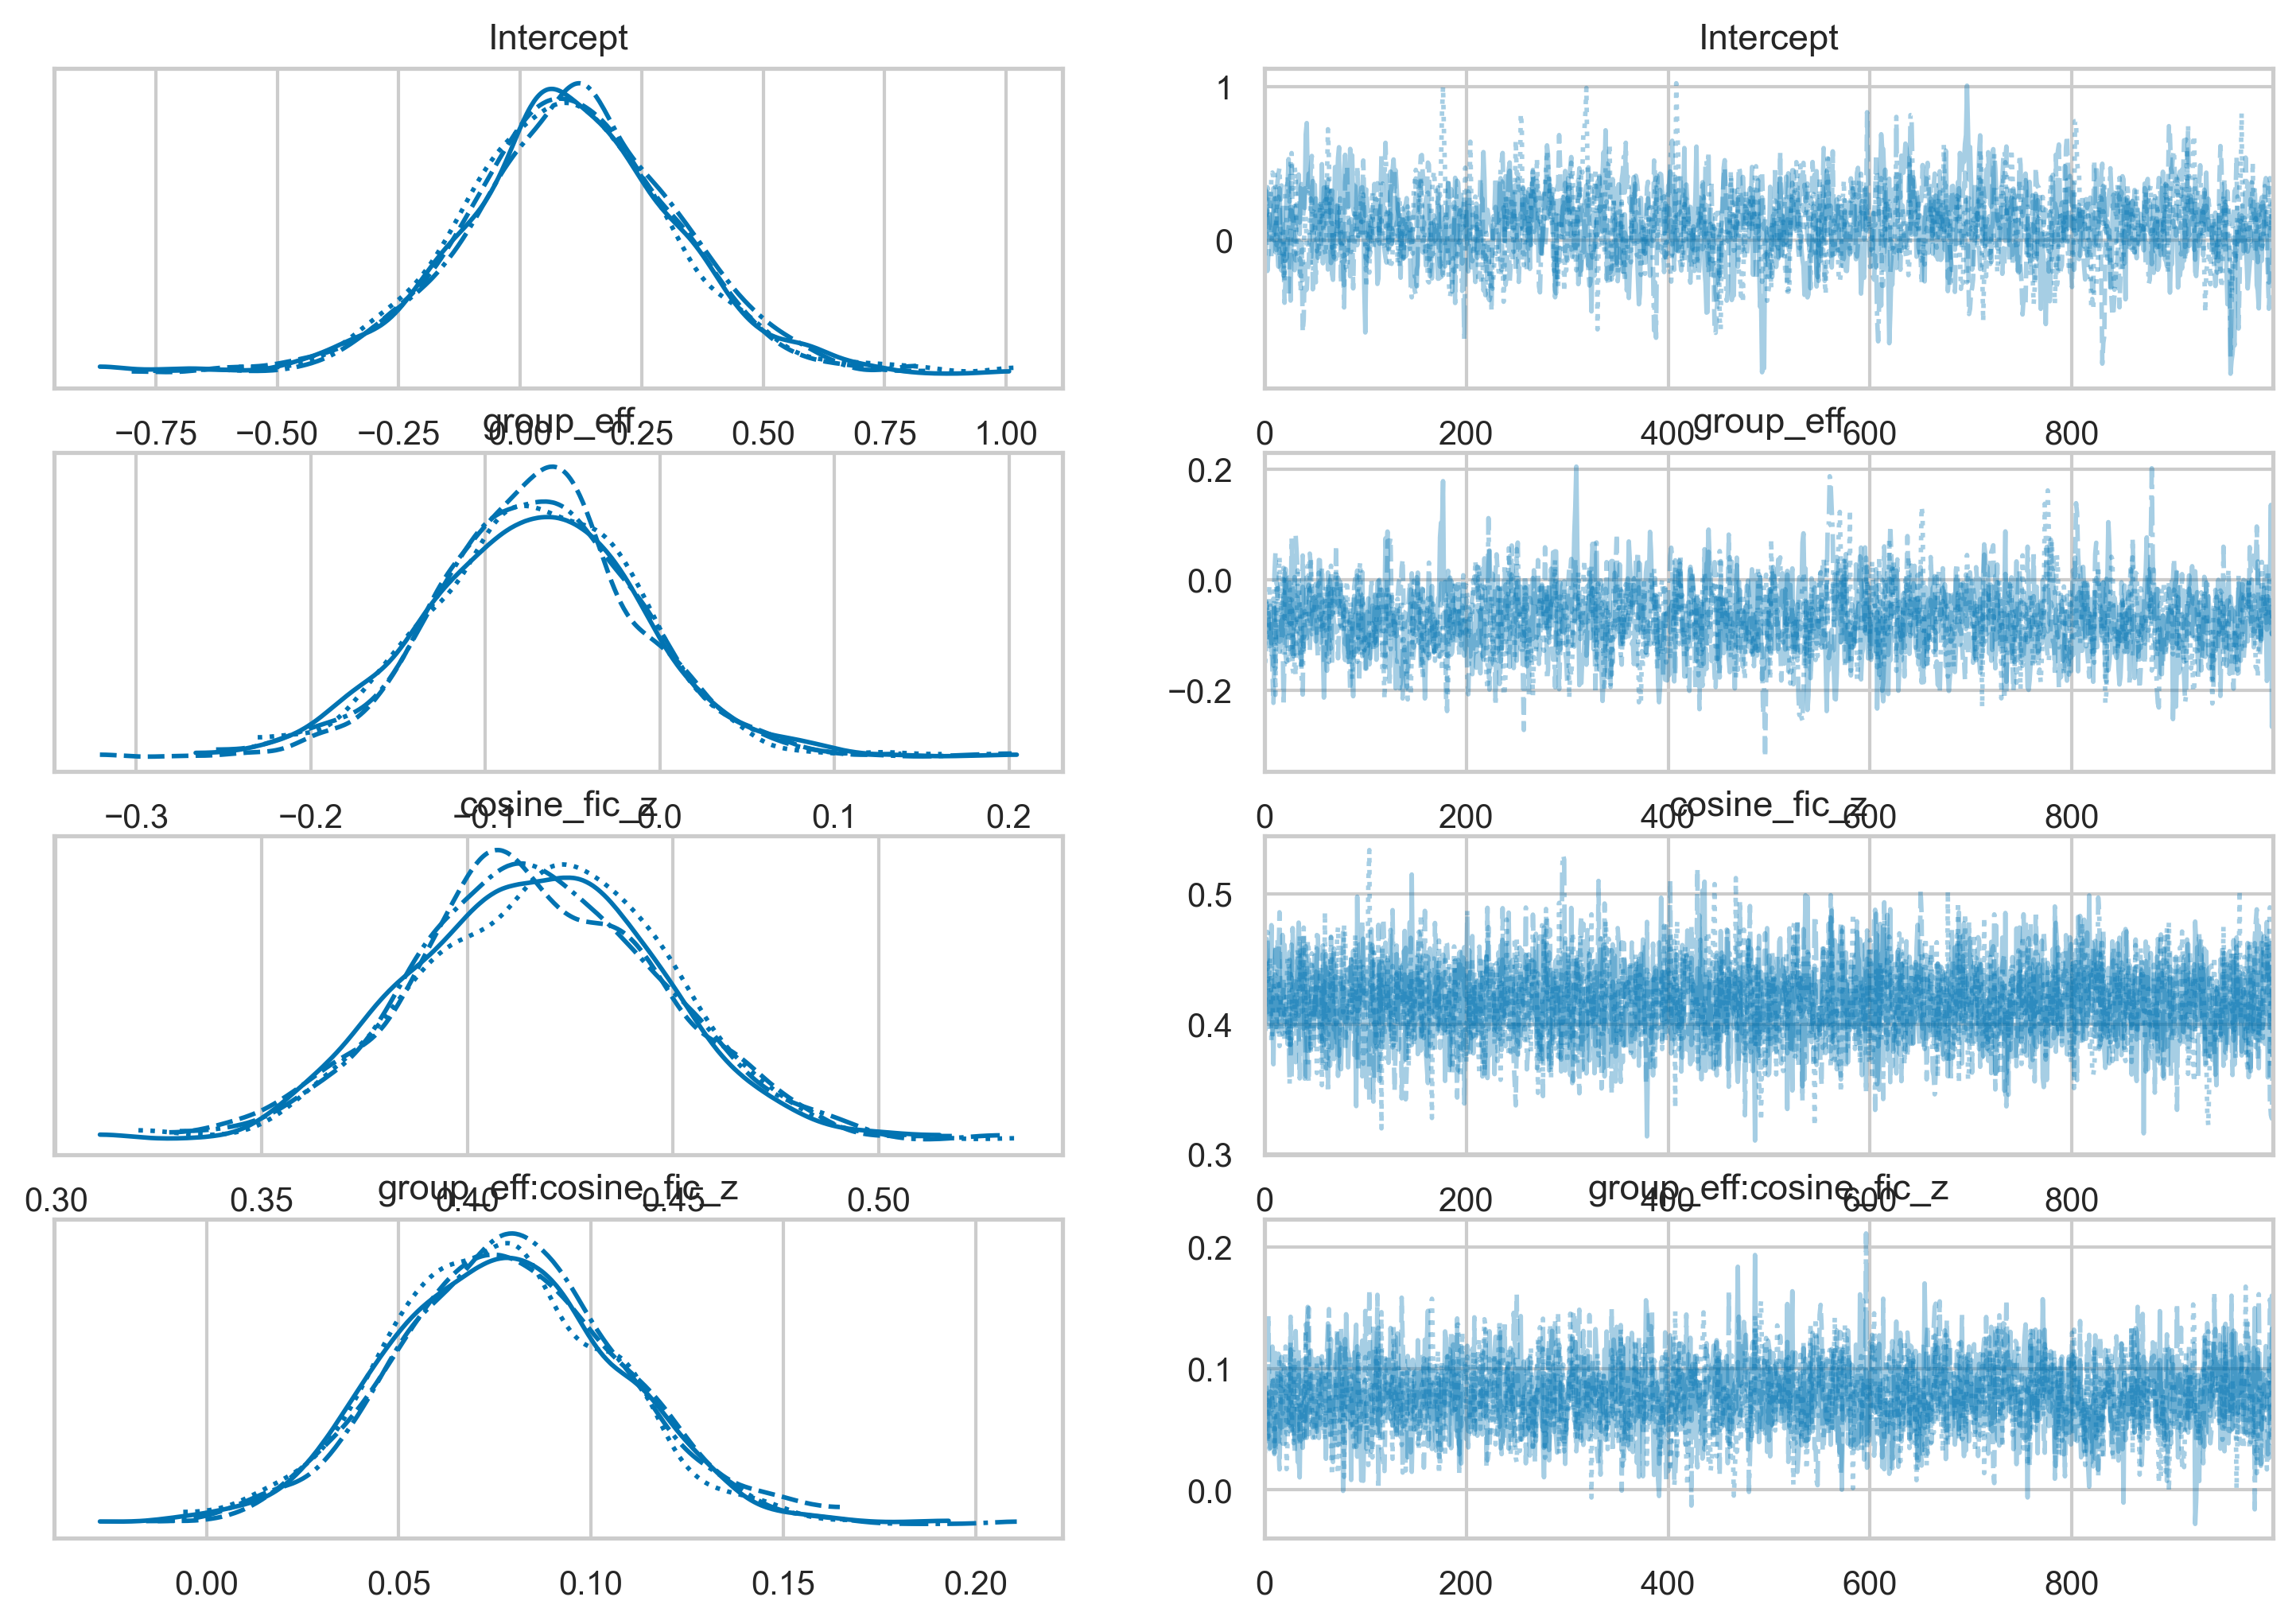

In [29]:
g = az.plot_trace(r_fic, var_names=['Intercept', 'group_eff', 'cosine_fic_z', 'group_eff:cosine_fic_z'])

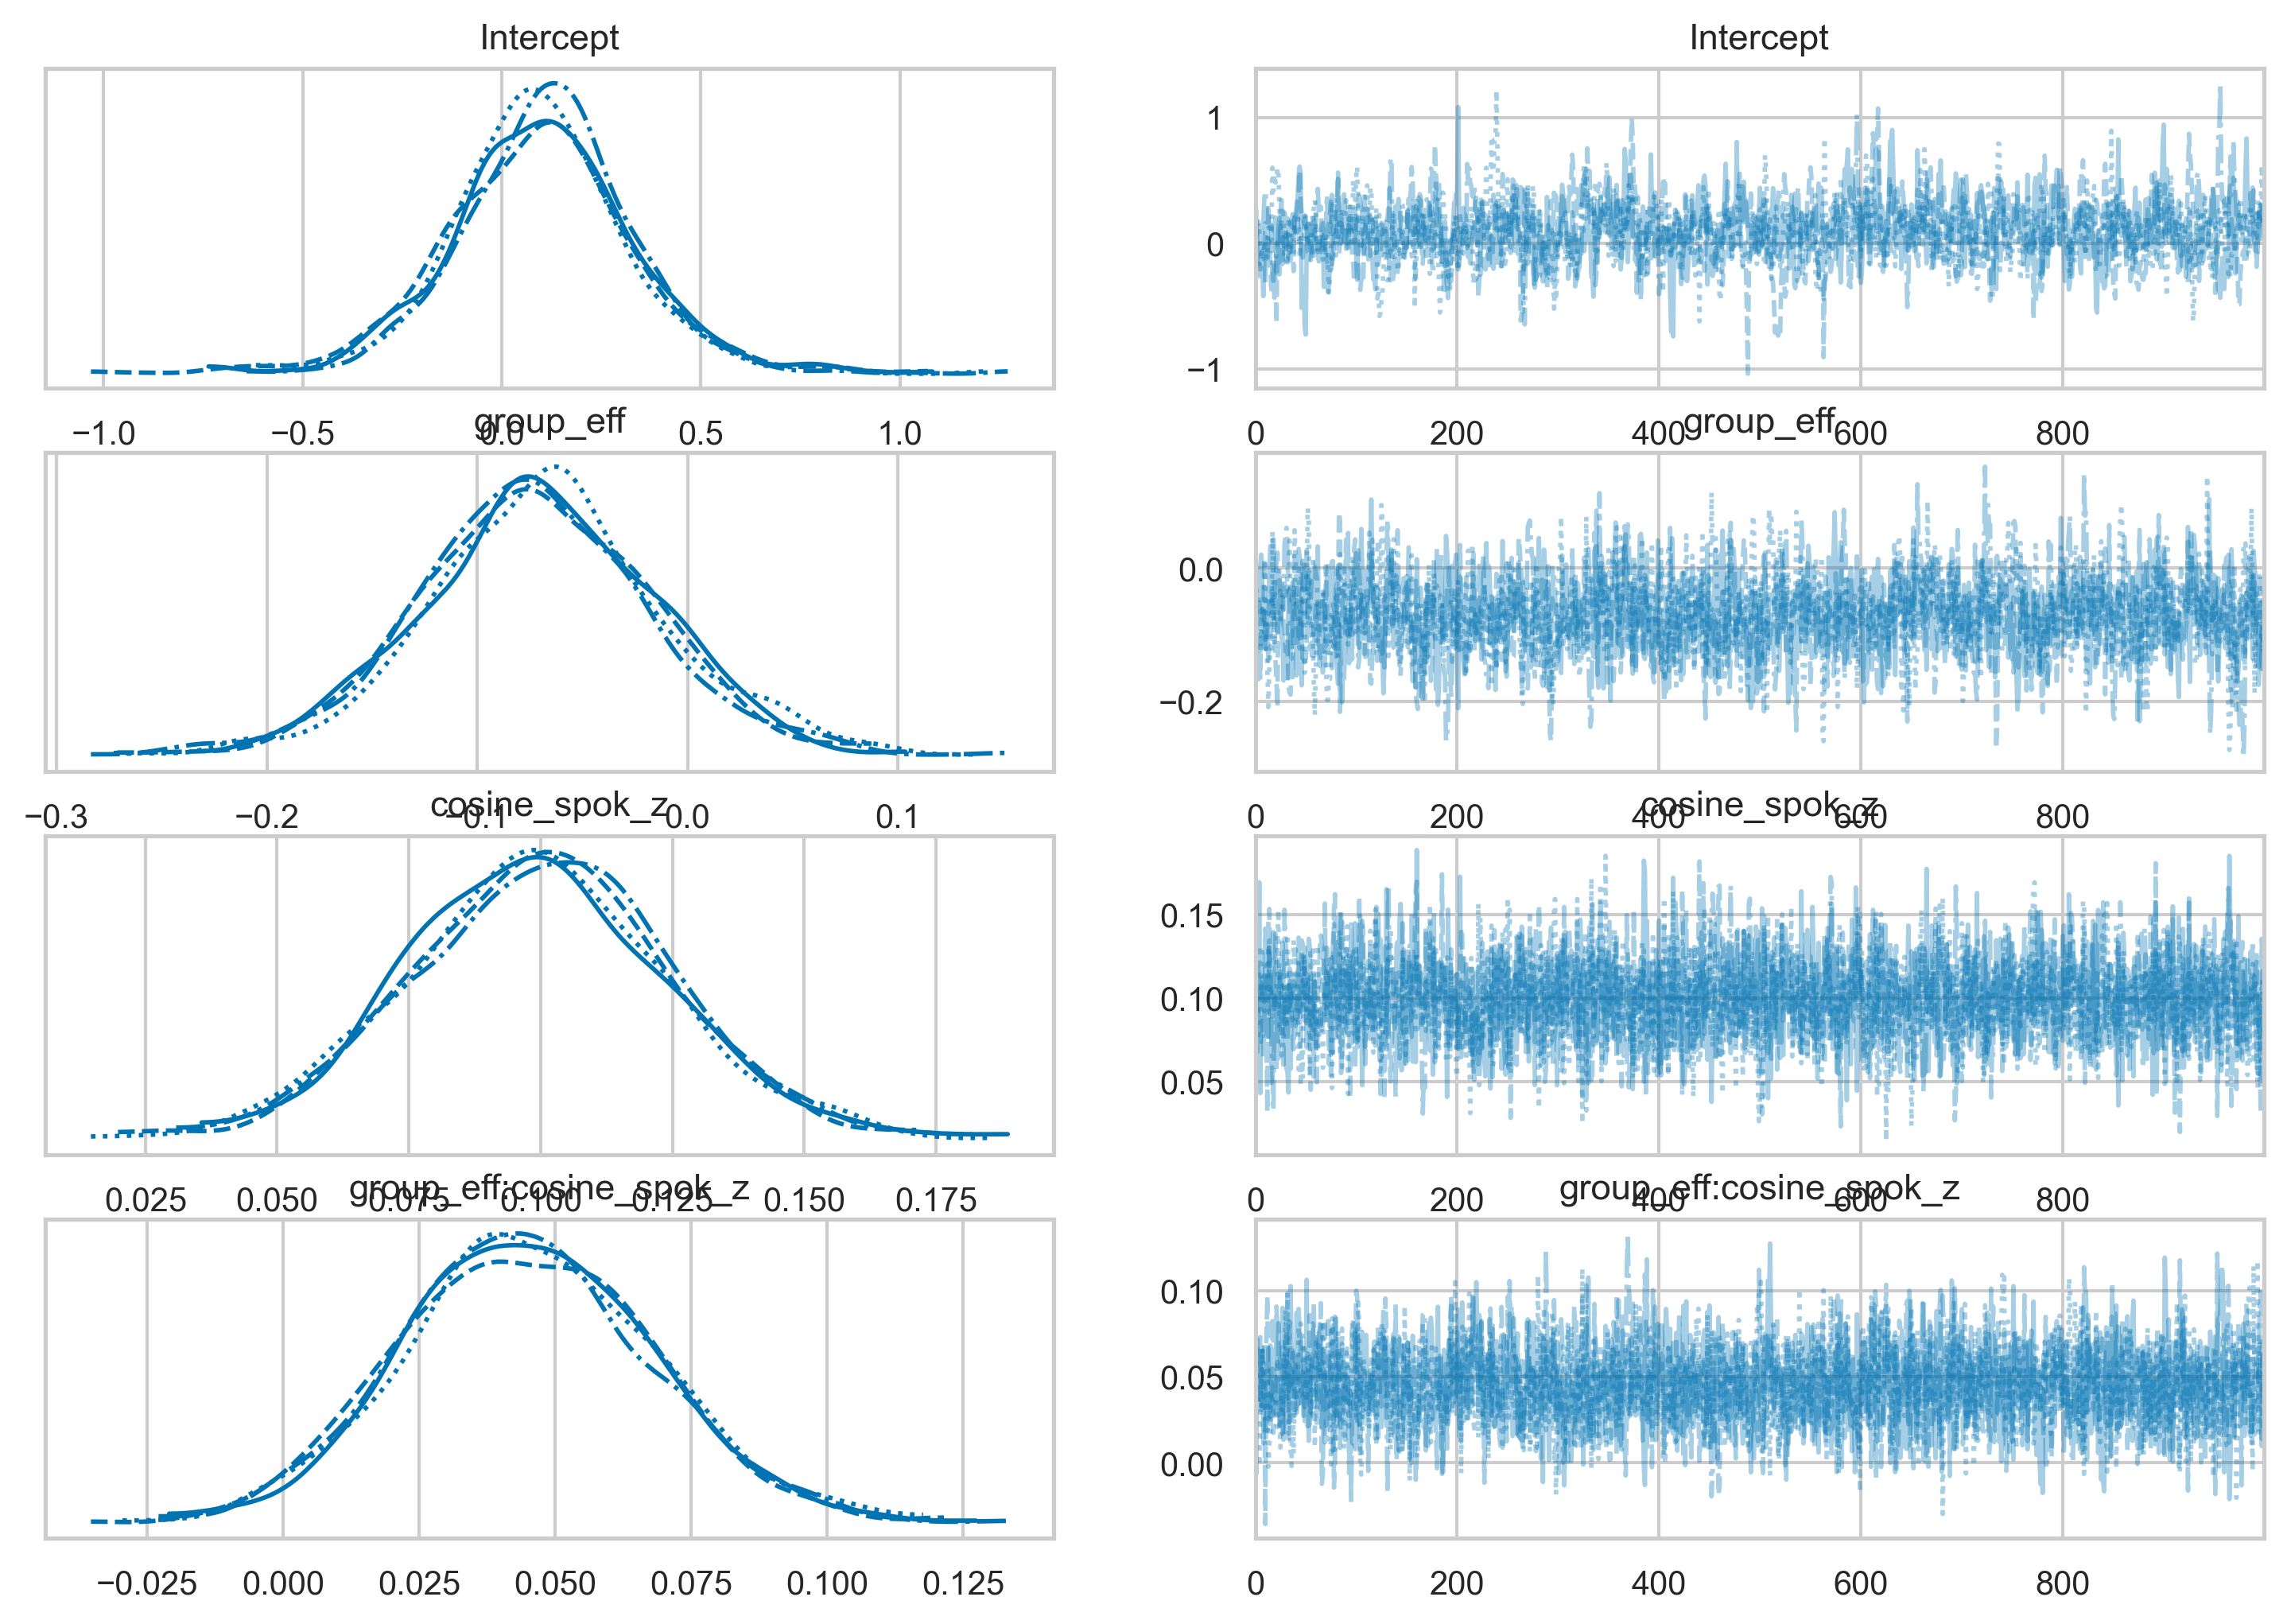

In [30]:
g = az.plot_trace(r_spok, var_names=['Intercept', 'group_eff', 'cosine_spok_z', 'group_eff:cosine_spok_z'])

### Cumulative posterior predictive check
Check if the model's predictions line up with the predictions in our observed data (i.e. there are no weird biases etc.)

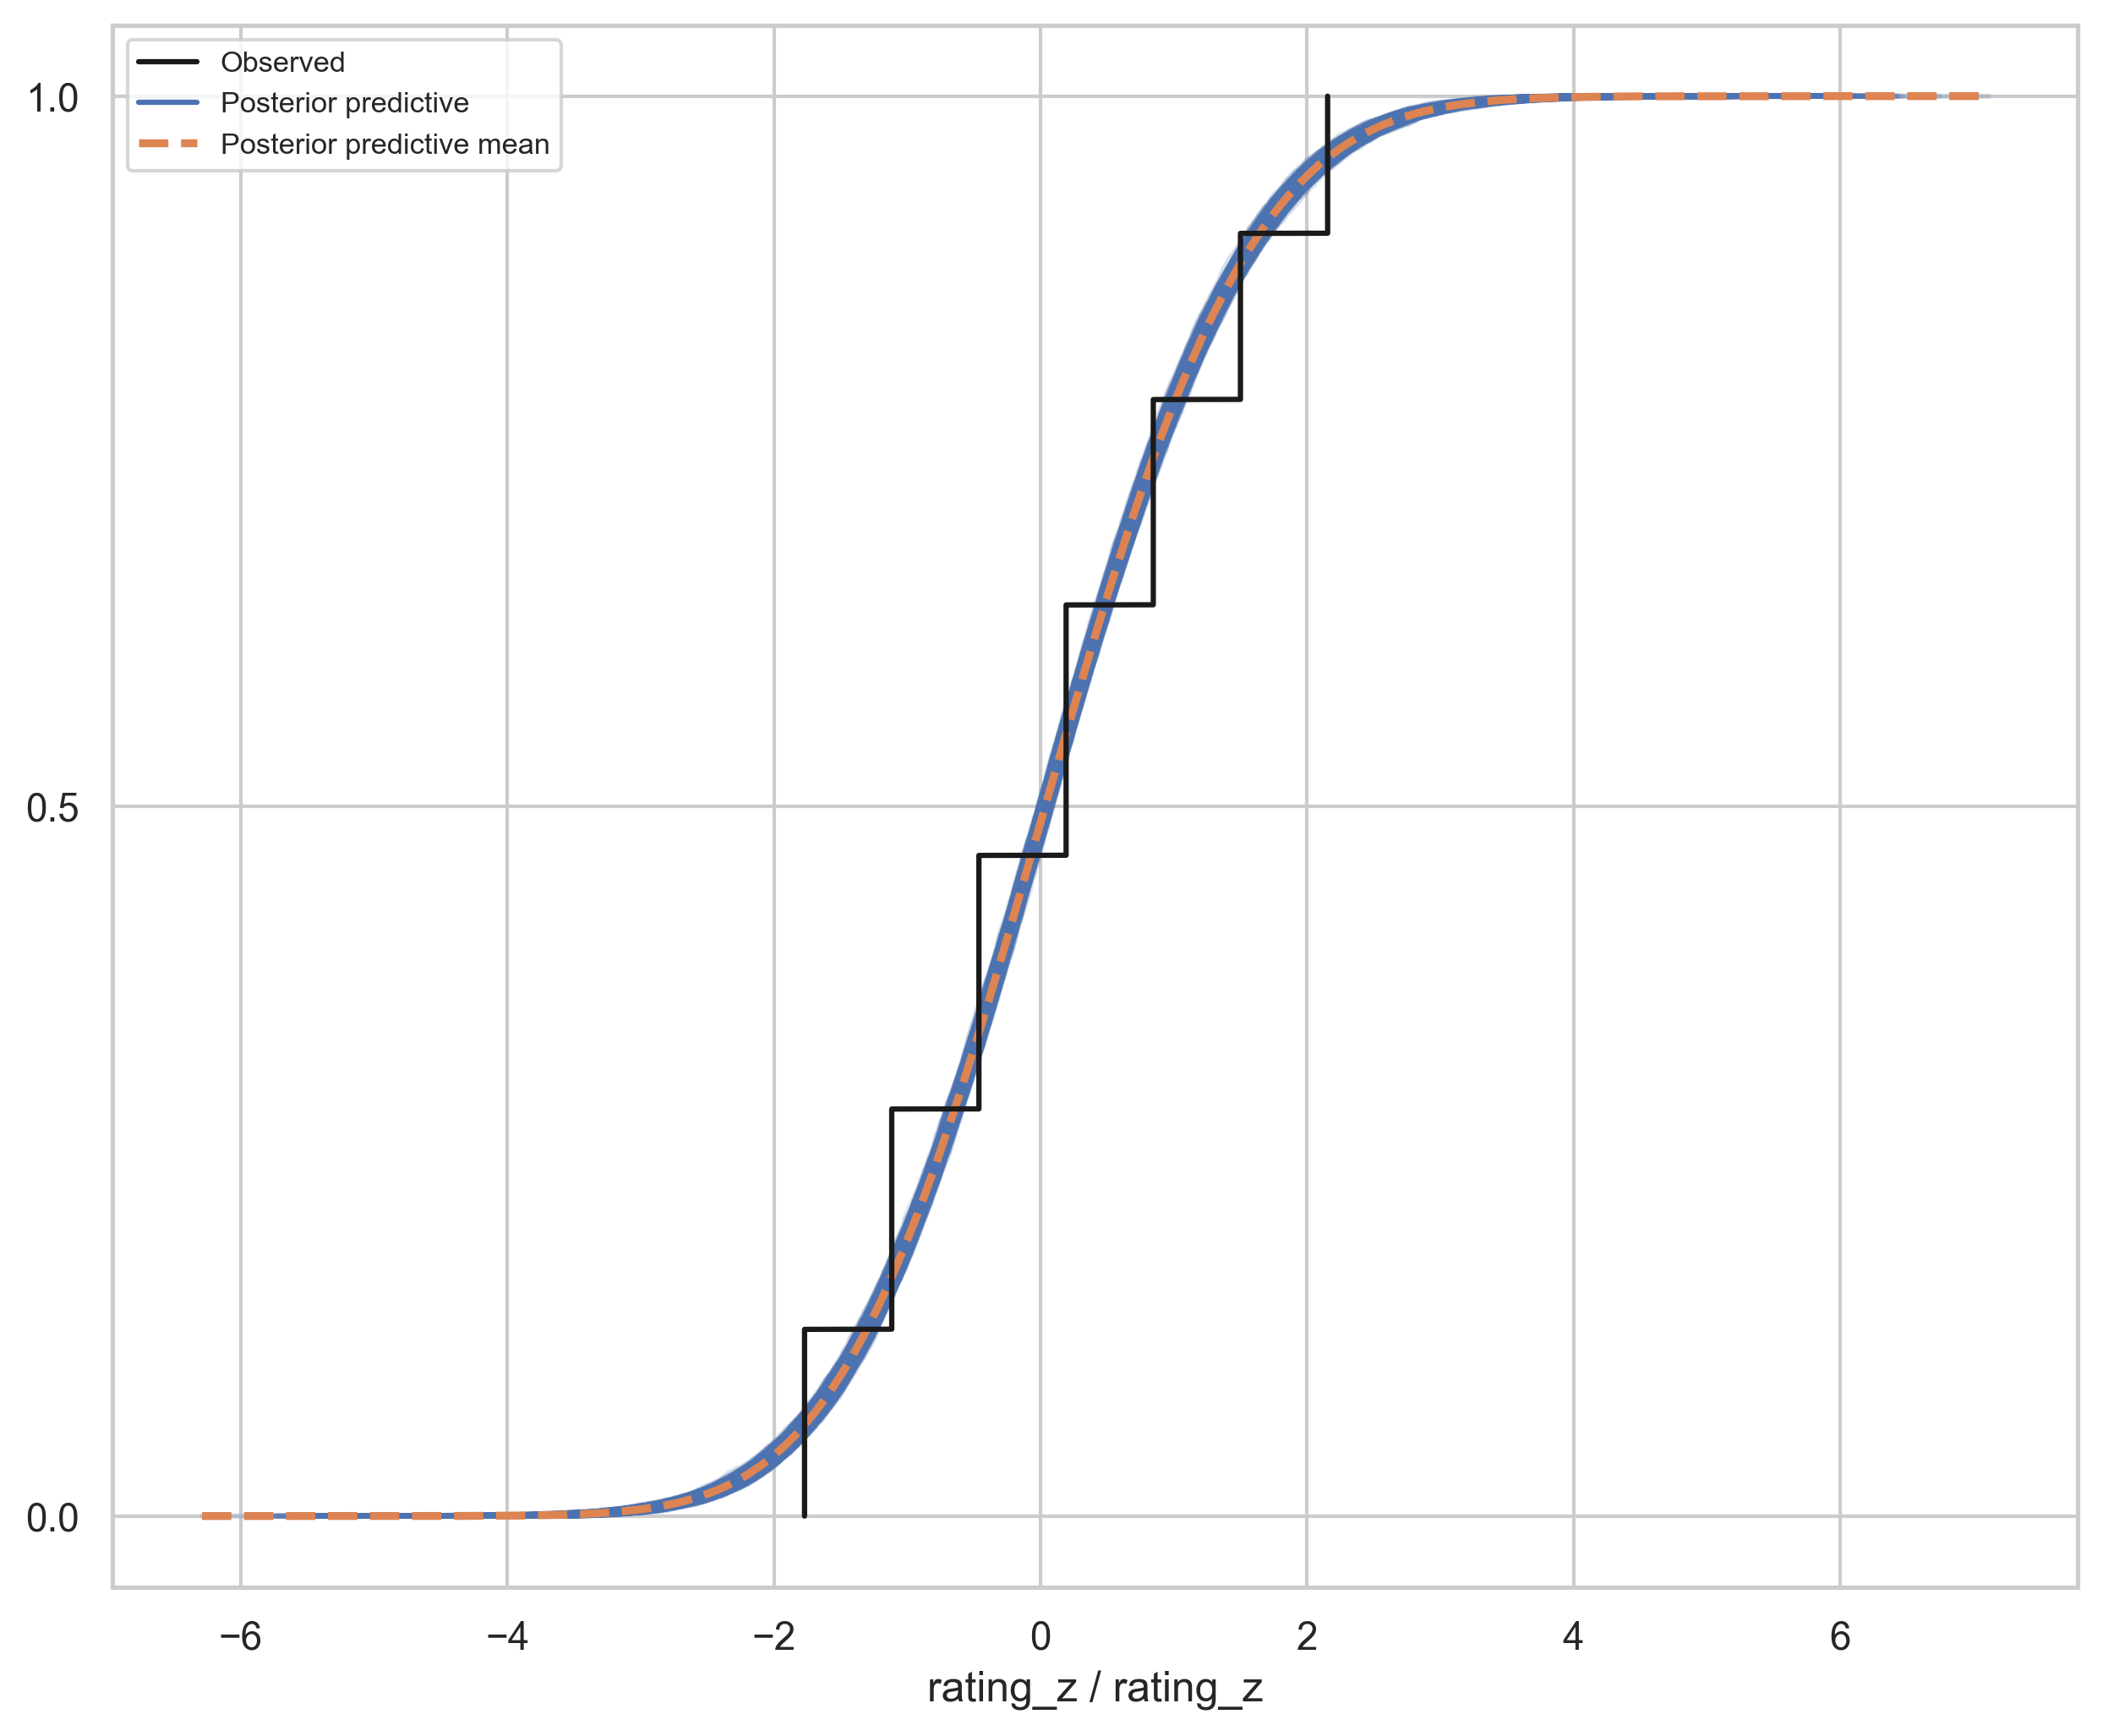

In [14]:
m_cc.predict(r_cc, kind='pps')
g = az.plot_ppc(r_cc, kind='cumulative')

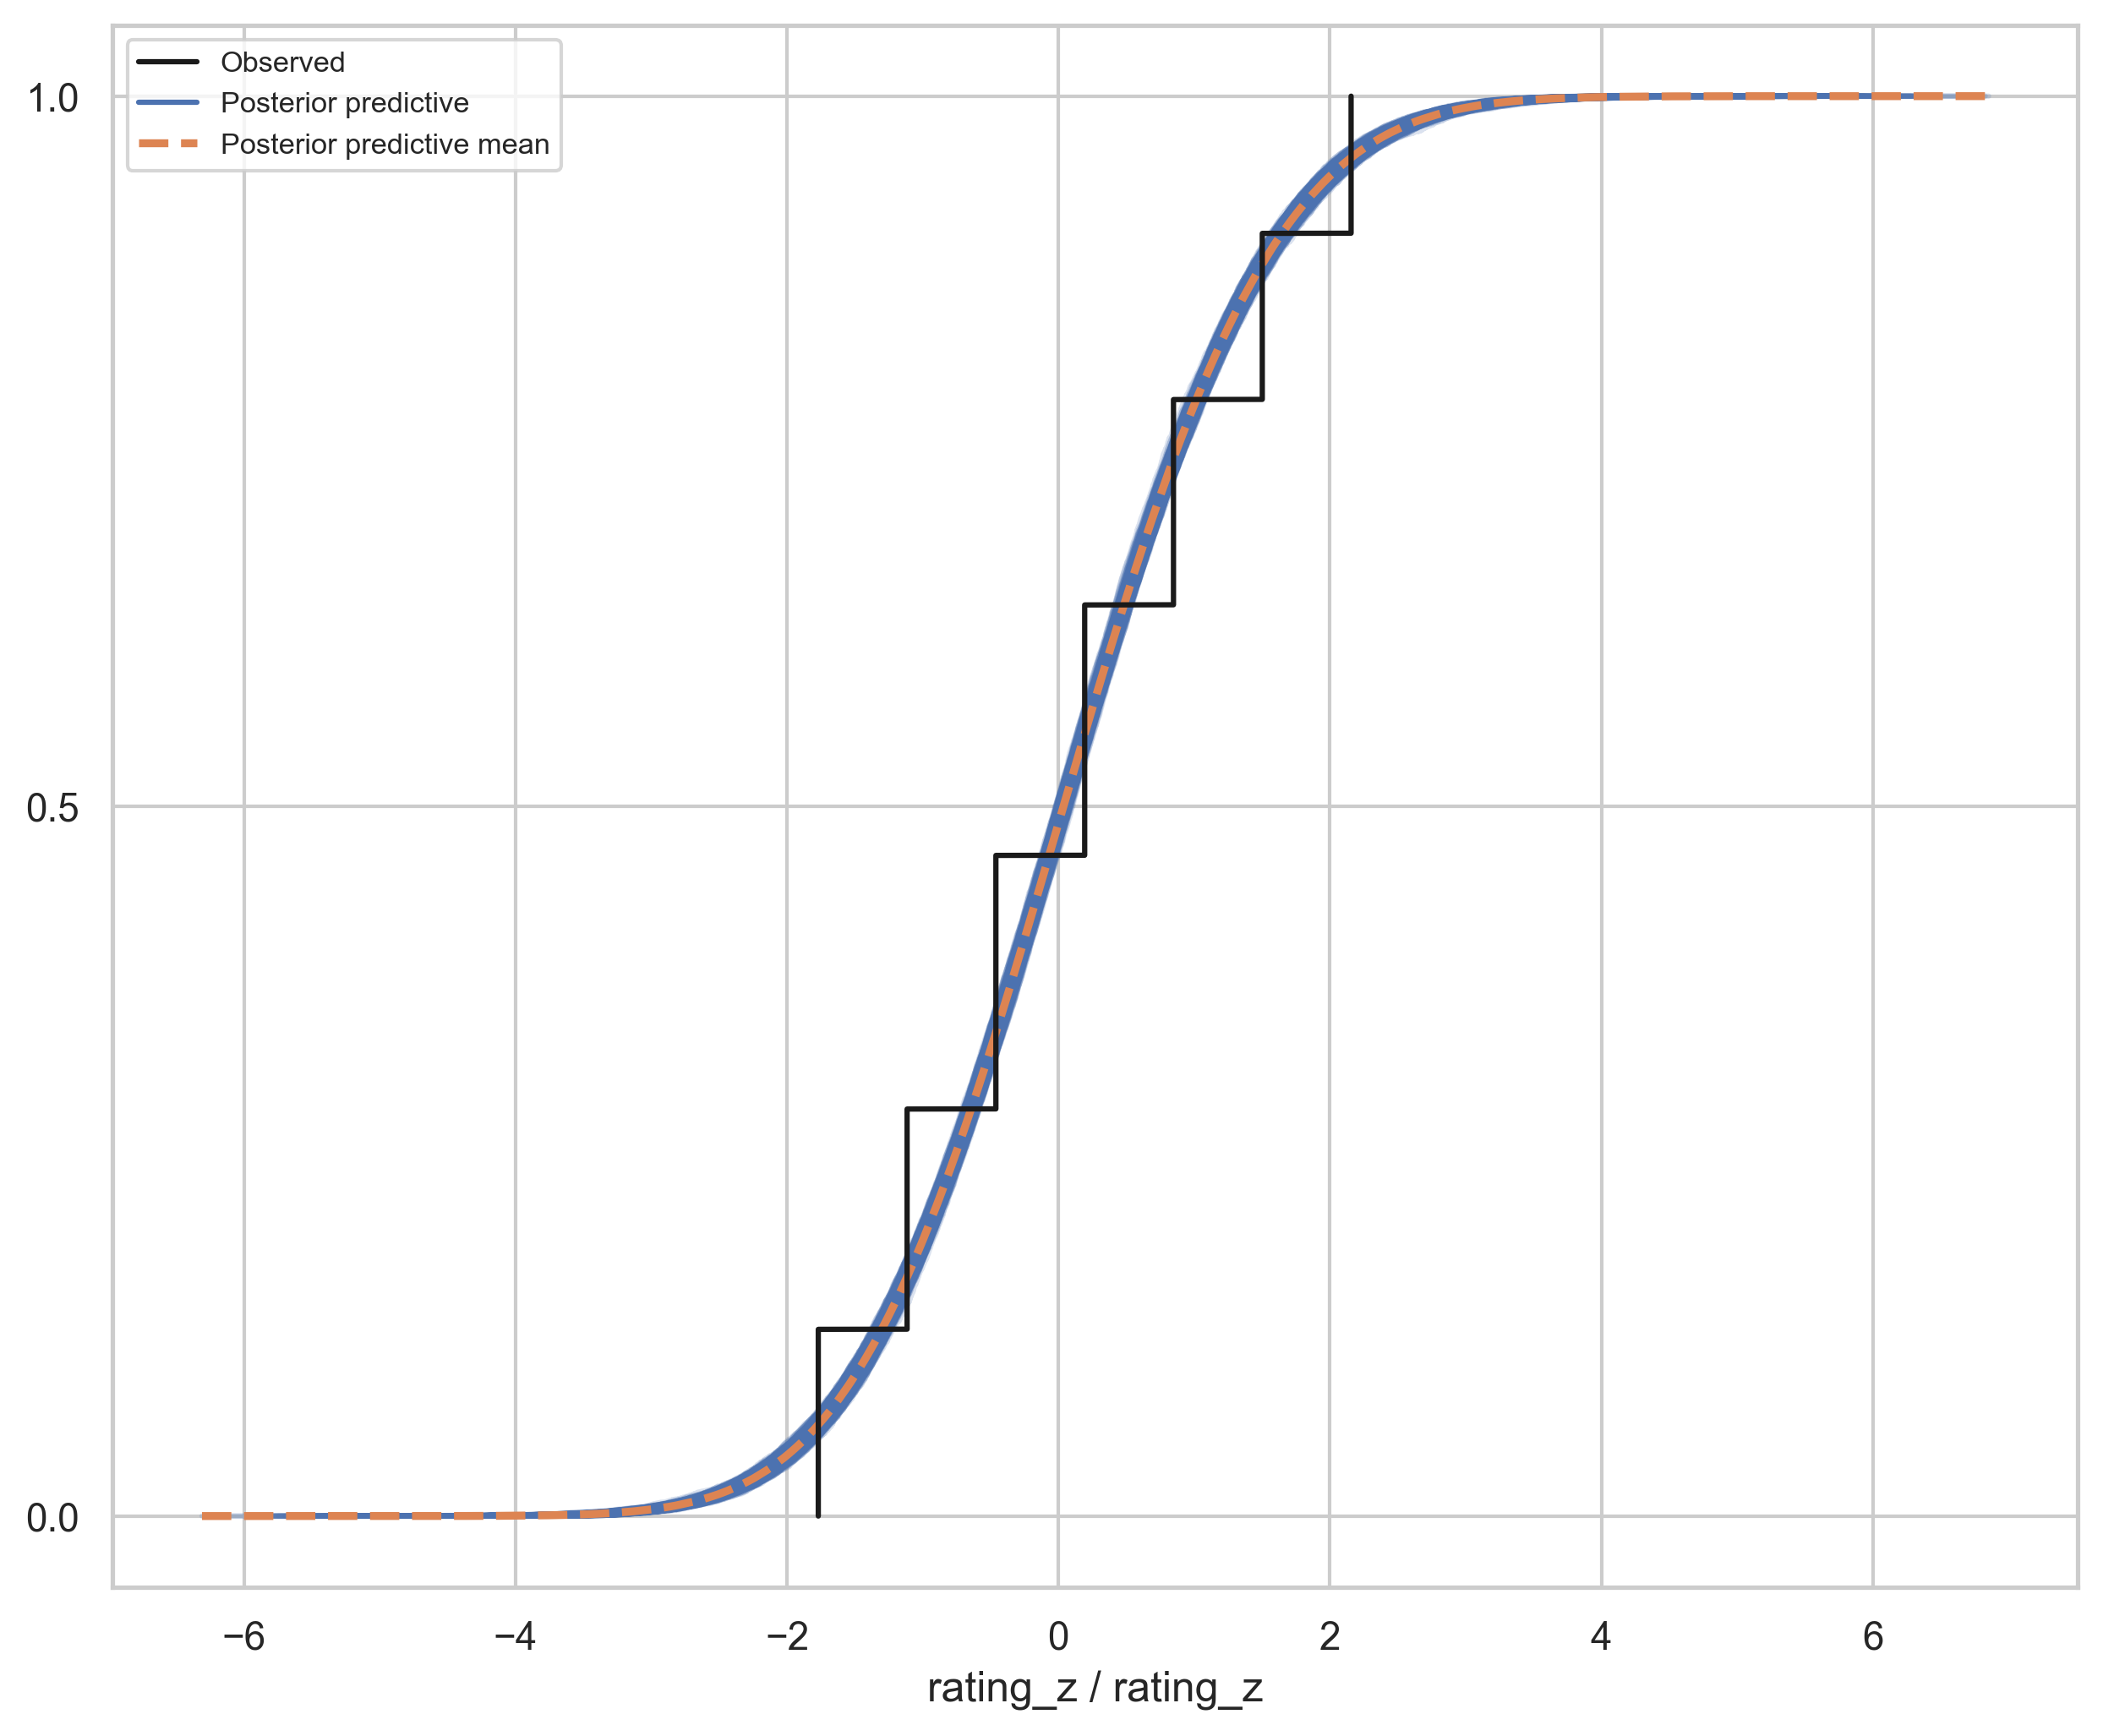

In [15]:
m_subs.predict(r_subs, kind='pps')
g = az.plot_ppc(r_subs, kind='cumulative')

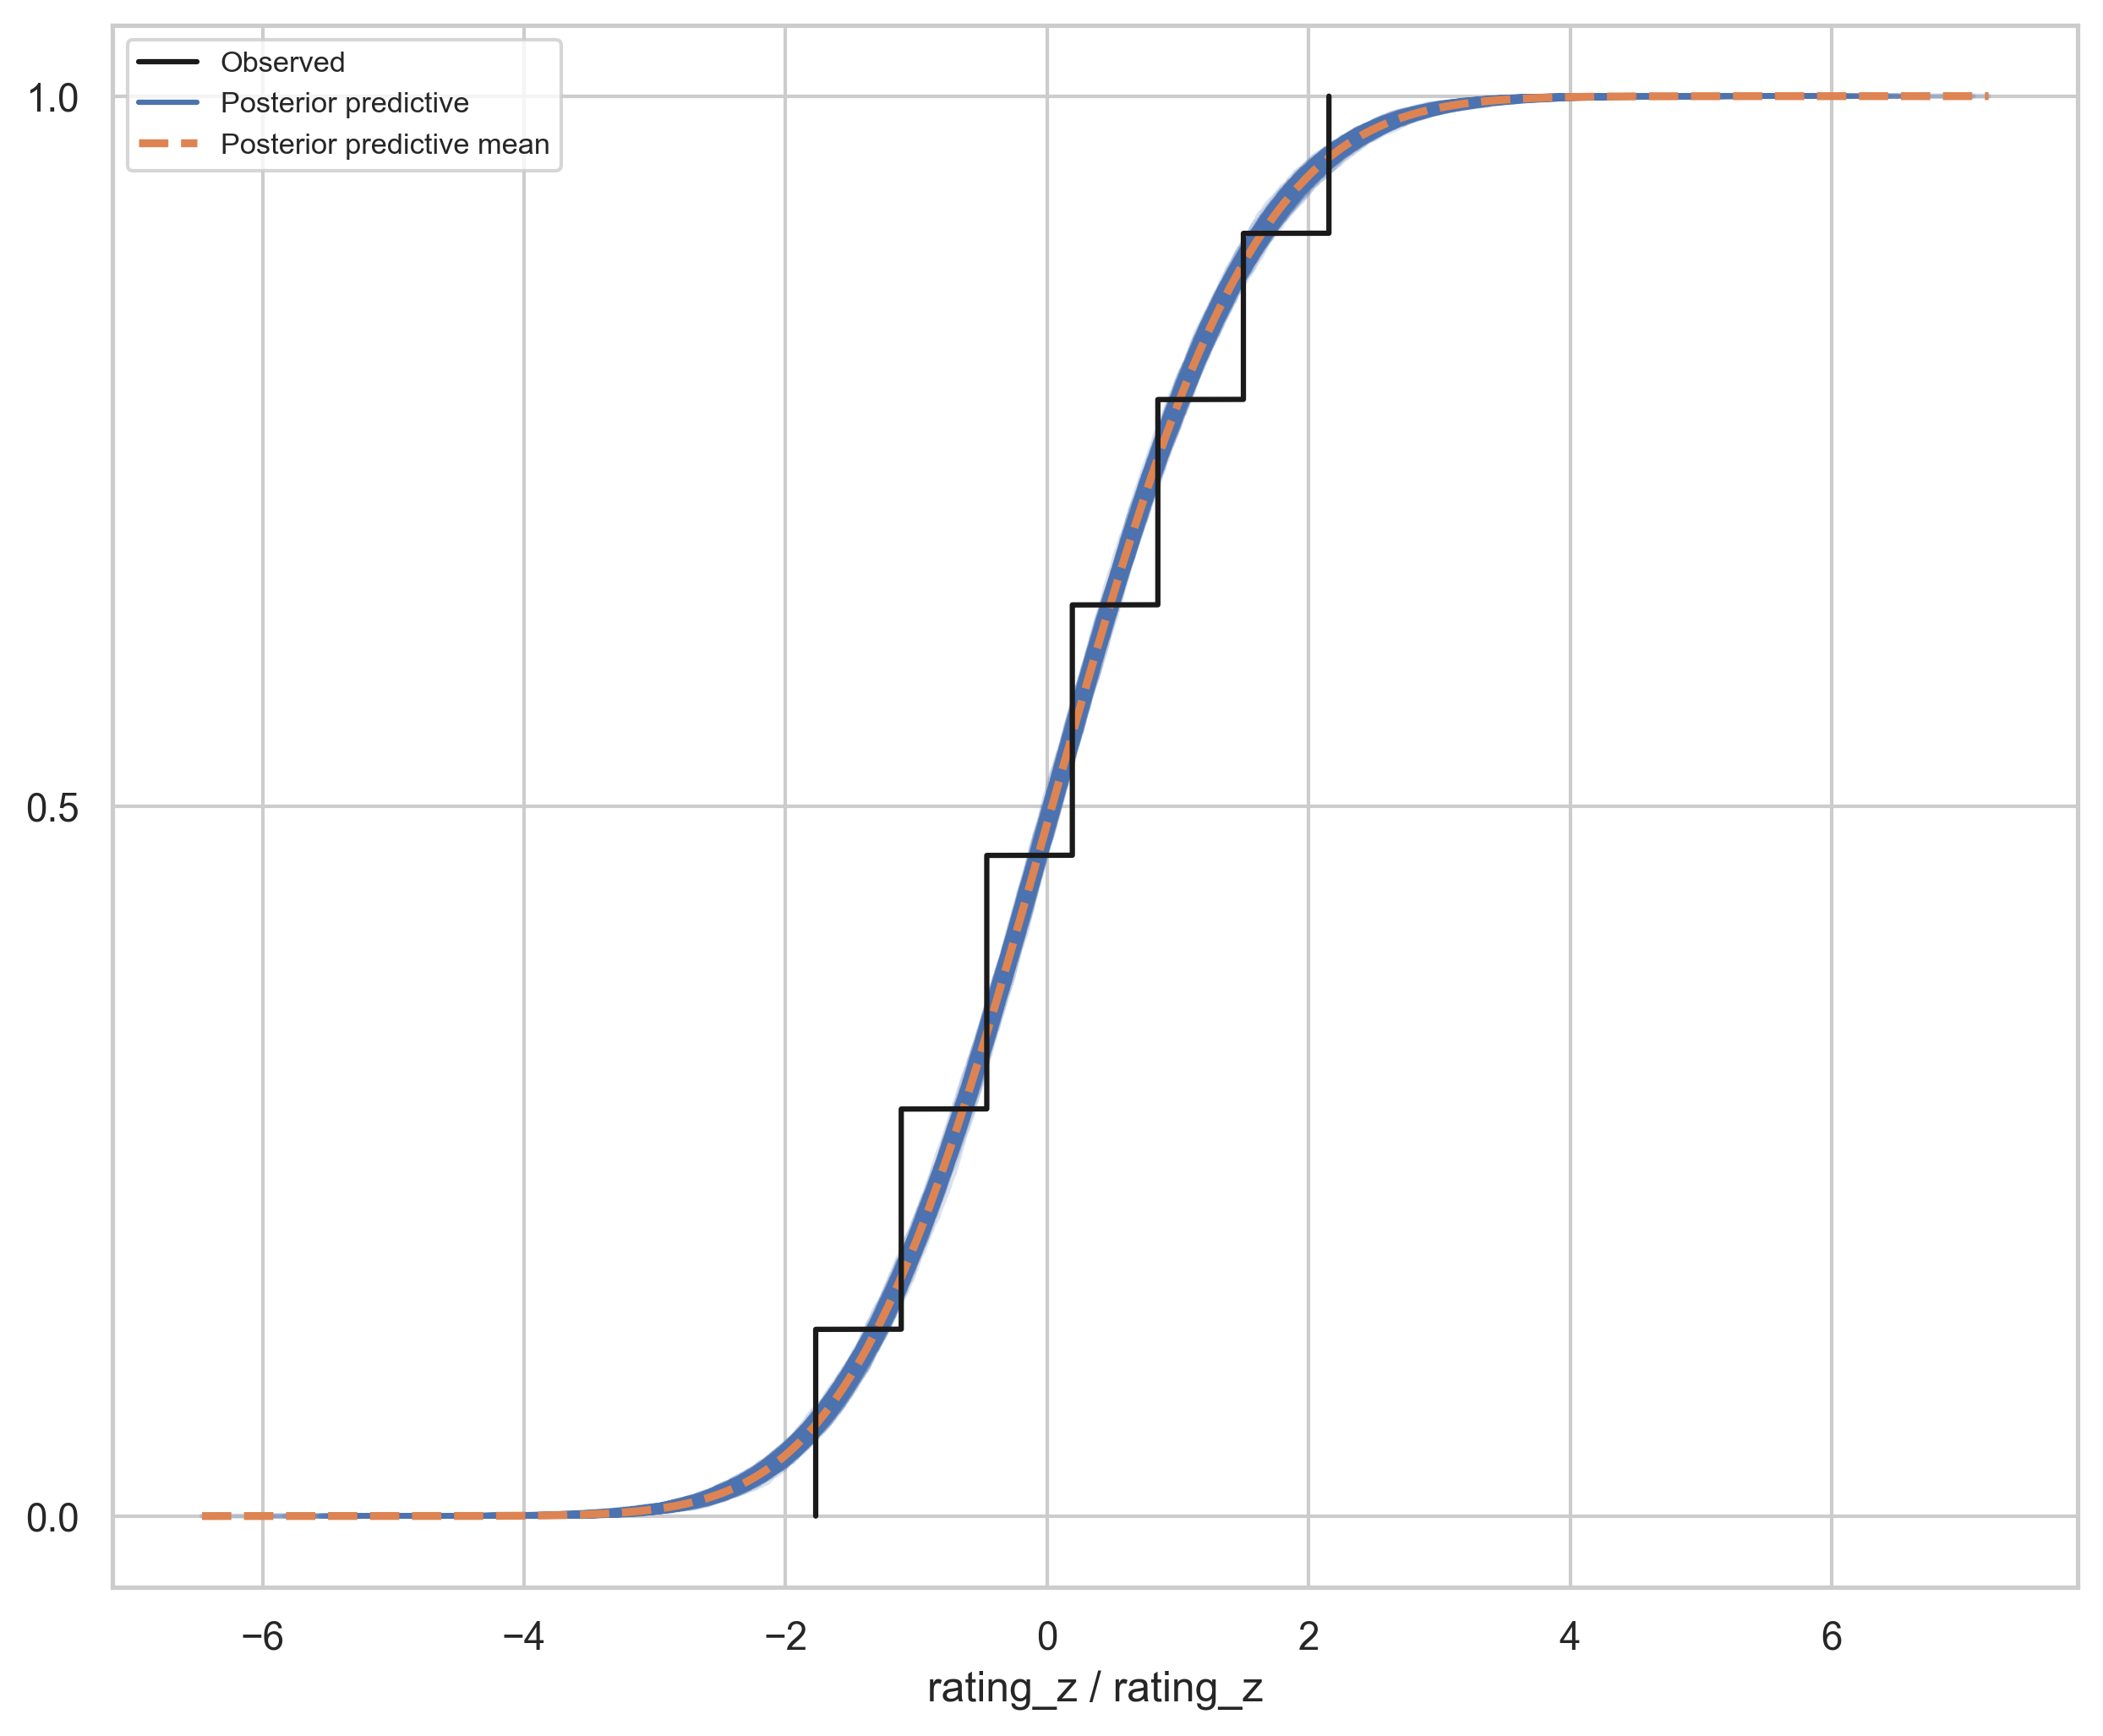

In [7]:
m_fic.predict(r_fic, kind='pps')
g = az.plot_ppc(r_fic, kind='cumulative')

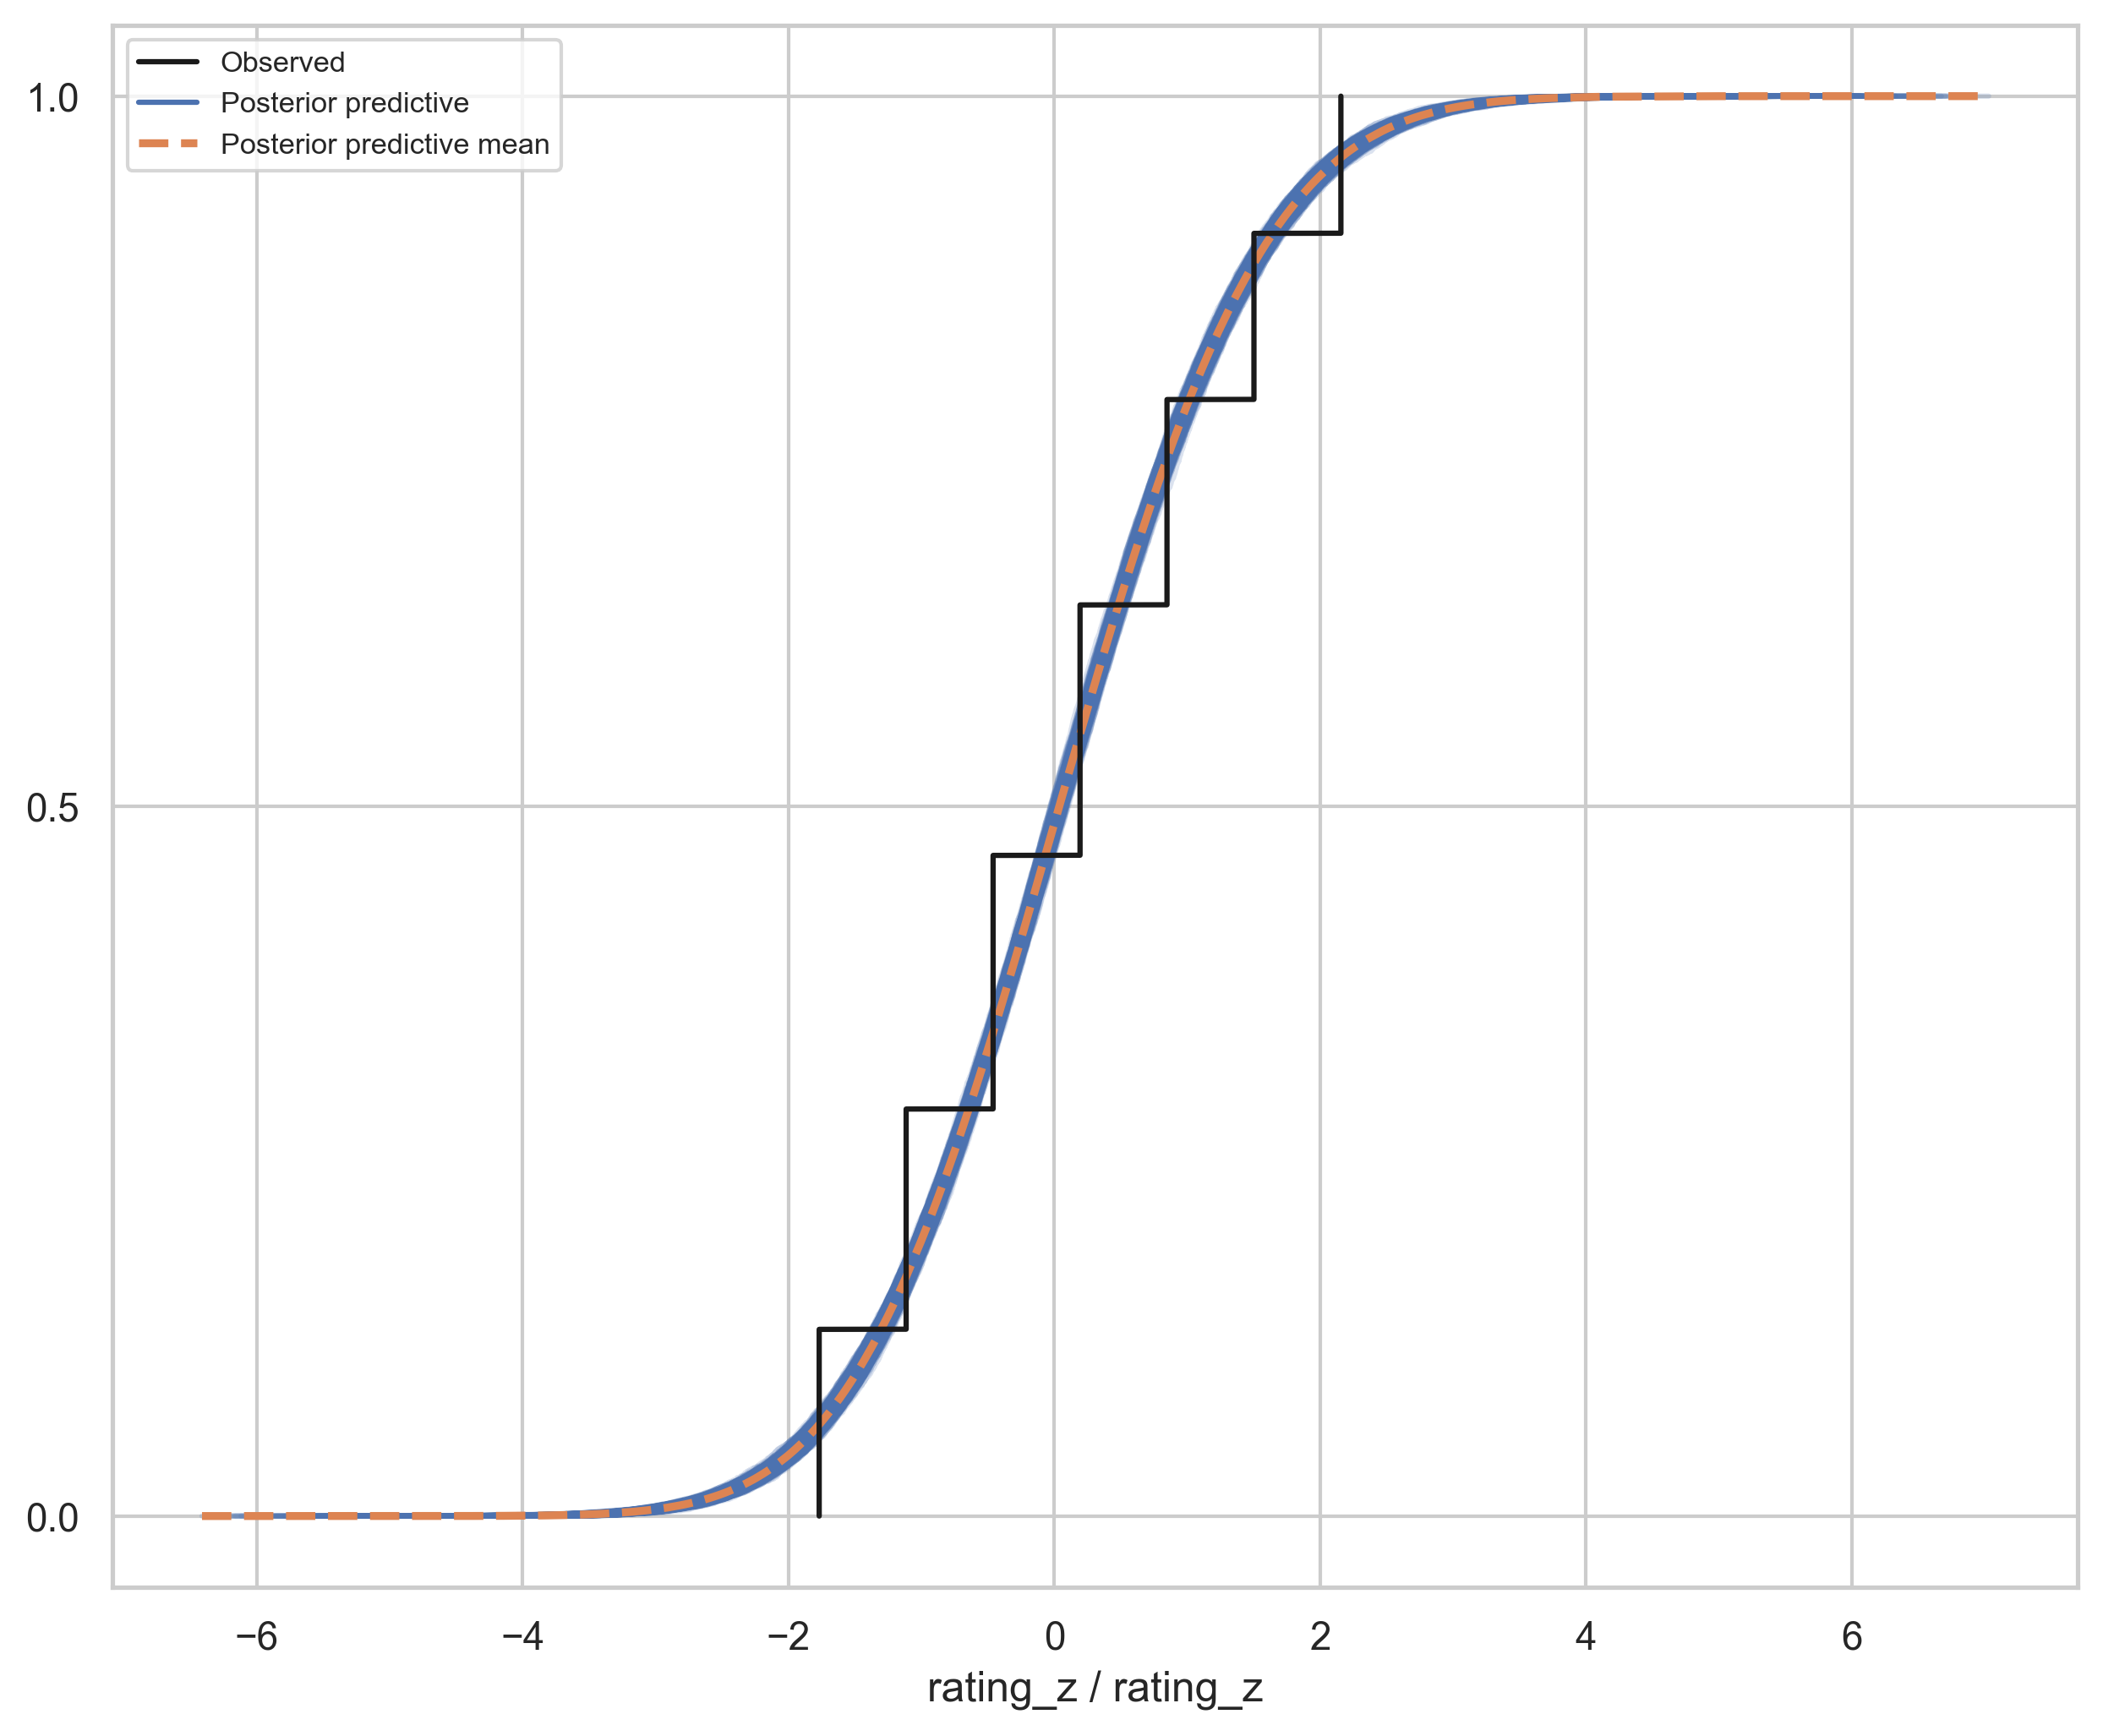

In [8]:
m_spok.predict(r_spok, kind='pps')
g = az.plot_ppc(r_spok, kind='cumulative')

# Convert notebook to html

In [9]:
convert_notebook('experiment_2')

Jupyter notebook `experiment_2` converted successfully.